# Evaluation on Synthetic Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_fscore_support
import benchmark as bm
from prismo import feature_sets as fs
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os

%matplotlib
%matplotlib inline

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: <object object at 0x7fb518a04b10>


In [3]:
device = "cuda"
seed = 2411111440
rng = np.random.default_rng(seed)

# Discrete colors
colors_disc = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99", "#FF99CC", "#99CCFF"]
# Continuous colors
colors_div = ["#214D83", "#7D1B26"] # blue, red


In [4]:
# n_samples = 400
# n_features = 2000
# n_factors = 40
# n_informative_factors=20
# # first 5 informative factors are removed
# start_factor_idx = 5
# # adds additional 5 uninformative factors
# end_factor_idx = 25

# corr_coef = 0.9

# sigma = 2
# sparsity_interval = (0.85, 0.99)
# noise_fraction = 0.4

# w, true_mask, z, x = muvi.bm.generate_spectra_5d(
#     rng,
#     n_samples,
#     n_features,
#     n_factors,
#     n_informative_factors=n_informative_factors,
#     corr_coef=corr_coef,
#     sparsity_interval=sparsity_interval,
#     sigma=sigma,
# )

# adata = ad.AnnData(x)
# noisy_mask = muvi.bm.get_rand_noisy_mask(rng, true_mask, noise_fraction, noise_fraction)

# true_mask = true_mask[start_factor_idx:end_factor_idx, :]
# noisy_mask = noisy_mask[start_factor_idx:end_factor_idx, :]
# terms = [f'factor_{k}' for k in range(z.shape[1])]

In [5]:
adata = ad.read_h5ad("../data/kang_tutorial.h5ad").copy()
adata.var_names = adata.var_names.str.upper()
adata._inplace_subset_var(adata.to_df().std() > 0.2)
# adata = ad.AnnData(adata.to_df())
# print(adata)

# adata = ad.read_h5ad("../data/pbmc3k_filtered_counts.h5ad").copy()
# adata.var_names = adata.var_names.str.upper()
# adata = ad.AnnData(adata.to_df())
# adata

# gene_set_collection = fs.from_gmt("top_overlap_dict_at_500.gmt")
# gene_set_collection = fs.from_gmt("../msigdb/h.all.v7.5.1.symbols.gmt")
gene_set_collection = fs.from_gmt("../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt")
gene_set_collection = gene_set_collection.filter(
    adata.var_names,
    min_fraction=0.4,
    min_count=40,
    max_count=200,
    # adata.var_names, min_fraction=0.1, min_count=5
)
print(gene_set_collection)

true_mask = gene_set_collection.to_mask(adata.var_names.tolist())
# true_mask = pd.read_csv('../data/common_mask_hallmark.csv', index_col=0)
terms = true_mask.index.tolist()


# noisy_mask = true_mask.copy()
# for k, v in top_overlap_dict.items():
#     noisy_mask.loc[k, :].iloc[sorted(v)] = rng.choice([True, False], len(v), replace=True)

true_mask = true_mask.values
noisy_mask = bm.get_rand_noisy_mask(rng, true_mask, fpr=0.3, fnr=0.3)

# true_mask = true_mask.values.astype(bool)
# noisy_mask = noisy_mask.values.astype(bool)

# subsamples = rng.choice(adata.obs_names, size=int(0.2 * adata.n_obs), replace=False)
# adata = adata[subsamples, :].copy()
adata

<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 120 feature sets>


AnnData object with n_obs × n_vars = 13576 × 4325
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

In [6]:
gene_set_collection

<FeatureSets 'c2.cp.reactome.v7.5.1.symbols.gmt' with 120 feature sets>

In [7]:
gene_set_collection.median_size

56

In [8]:
adata.var_names

Index(['NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'UBE2J2',
       'CPSF3L', 'AURKAIP1', 'CCNL2',
       ...
       'PFKL', 'SUMO3', 'PTTG1IP', 'ITGB2', 'FAM207A', 'PRMT2', 'CXCL13',
       'CH25H', 'HRASLS2', 'NUPR1'],
      dtype='object', name='index', length=4325)

In [9]:
average_precision_score((true_mask).flatten(), noisy_mask.flatten())

0.5043563427464821

In [10]:
precision_recall_fscore_support((true_mask).flatten(), noisy_mask.flatten())

(array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([1.  , 0.71]),
 array([510538,   8462]))

In [11]:
adata.to_df().std().sort_values()

index
CDK17          0.200018
COPS7A         0.200113
COQ9           0.200169
REEP4          0.200202
SECISBP2L      0.200210
                ...    
CXCL10        42.343552
MALAT1        47.035679
ISG15         56.350231
FTL          115.172829
FTH1         183.326508
Length: 4325, dtype: float32

In [12]:
(np.nanmin(adata.X, axis=0) > 0).sum()

2

In [13]:
x = adata.X
x = x - x.min(axis=0)
log_x = np.log1p(x)
log_x = log_x / log_x.std()
log_x_centered = log_x - log_x.mean(axis=0)
log_x_stdised = log_x_centered / log_x_centered.std()

In [14]:
data_dict = {
    "expimap": log_x_centered.astype(np.float32),
    "expimap_nb": x.astype(np.float32),
    "expimap_hardmask": log_x_centered.astype(np.float32),
    "expimap_hardmask_nb": x.astype(np.float32),
    "spectra": log_x.astype(np.float32),
    "prismo": log_x_centered.astype(np.float32),
    "prismo_nmf": log_x.astype(np.float32),
}

In [15]:
model_dict = {}

In [16]:
# for soft_mask in [True, False]:
#     for recon_loss in ["mse", "nb"]:
# for alpha_l1 in [0.01, 0.1, 0.4, 0.8]:
for soft_mask in [True]:
    for recon_loss in ["mse"]:
        model_name = "expimap"
        if not soft_mask:
            model_name += "_hardmask"
        if recon_loss == "nb":
            model_name += "_nb"
        # model_name = f"{model_name}_{alpha_l1}"
        data_name = data_dict[model_name.split("_")[0]]
        model_dict[model_name] = bm.train_expimap(
            data_name,
            noisy_mask,
            seed=seed,
            terms=terms,
            recon_loss=recon_loss,
            # alpha_l1=alpha_l1,
            n_epochs=1000,
            batch_size=1000,
            soft_mask=soft_mask,
            hidden_size_1=512,
            hidden_size_2=256,
        )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4325 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 120
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  120 0 0 1 4325
	with soft mask.
Last Decoder layer: identity
The default value of alpha_kl was changed to 0.35. from 1. This may case inconsistency with previous training results. Set alpha_kl=1. to reproduce the previous results.
alpha_epoch_anneal is used by default now. This may case inconsistency with previous training results. Set alpha_epoch_anneal=None to reproduce the previous results.
Preparing (13576, 4325)
Instantiating dataset
 |██------------------| 14.8%  - epoch_loss: 1496.6728046124 - epoch_recon_loss: 1435.7452768179 - epoch_kl_loss: 174.0786766639 - val_loss: 1493.9614868164 - val_recon_loss: 1433.1778564453 - val_kl_loss: 173.6675949097
ADJUSTED LR
 |███-----------------| 17.4%  - epoch_loss: 1481.1553297776 - epoch_recon_loss: 1420

In [17]:
# model_dict["spectra"] = bm.train_spectra(
#     data_dict["spectra"], noisy_mask, seed=seed, terms=terms, num_epochs=10
# )

In [18]:
data_dict.keys()

dict_keys(['expimap', 'expimap_nb', 'expimap_hardmask', 'expimap_hardmask_nb', 'spectra', 'prismo', 'prismo_nmf'])

In [19]:
noisy_mask.shape

(120, 4325)

In [20]:
# VS_CODE_REMOTE = True
# if VS_CODE_REMOTE:
#     os.chdir(pathlib.Path().absolute() / "benchmark")
#     import benchmark as bm

In [21]:
for model_name in ["prismo", "prismo_nmf"]:  #
    nmf = ("nmf" in model_name) or ("nb" in model_name)
    # for prior_confidence in [0.99, 0.999]:
    # model_dict[f"{model_name}-{prior_confidence}"] = muvi.bm.train_muvi(
    prior_penalty = 0.005
    # model_dict[f"{model_name}_{max_epochs}"] = bm.train_prismo(
    model_dict[model_name] = bm.train_prismo(
        data_dict[model_name],
        noisy_mask,
        seed=seed,
        terms=terms,
        obs_names=adata.obs_names.copy(),
        var_names=adata.var_names.copy(),
        n_factors=3,
        nmf=nmf,
        prior_penalty=prior_penalty,
        max_epochs=10000,
        batch_size=0,
        n_particles=1,
        lr=0.003,
        early_stopper_patience=100,
        device=device,
        true_mask=true_mask,
    )

# muvi.save(model_dict["muvi"], "benchmark_data_muvi_model")
# model_dict["muvi"] = muvi.load("benchmark_data_muvi_model")

2024-11-12 14:40:32 | prismo.prismo | INFO | Setting up device...
INFO:prismo.prismo:Setting up device...
2024-11-12 14:40:33 | prismo.prismo | INFO | - Checking compatibility of provided likelihoods with data.
INFO:prismo.prismo:- Checking compatibility of provided likelihoods with data.
2024-11-12 14:40:33 | prismo.prismo | INFO |   - view_0: Normal
INFO:prismo.prismo:  - view_0: Normal
2024-11-12 14:40:35 | prismo.prismo | INFO | Initializing factors using `random` method...
INFO:prismo.prismo:Initializing factors using `random` method...
2024-11-12 14:40:35 | prismo.prismo | INFO | Decaying learning rate over 10000 iterations.
INFO:prismo.prismo:Decaying learning rate over 10000 iterations.
2024-11-12 14:40:35 | prismo.prismo | INFO | Setting training seed to `2411111440`.
INFO:prismo.prismo:Setting training seed to `2411111440`.
2024-11-12 14:40:35 | prismo.prismo | INFO | Cleaning parameter store.
INFO:prismo.prismo:Cleaning parameter store.
2024-11-12 14:40:36 | prismo.prismo | 

In [22]:
model = model_dict["prismo"]
model

In [24]:
for k in model_dict:
    if "prismo" not in k:
        continue
    model_dict[k].factor_order = np.arange(model_dict[k].model_opts.n_factors)
    model_dict[k]._factor_order = np.arange(model_dict[k].model_opts.n_factors)
    model_dict[k].sample_names["group_1"] = adata.obs_names.tolist()
    model_dict[k].feature_names["view_0"] = adata.var_names.tolist()

In [25]:
# data_dict["famo"] = model_dict["famo"].data["group_1"]["view_0"].X

In [26]:
# for model_name in ["muvi"]:
#     nmf = ("nmf" in model_name) or ("nb" in model_name)
#     likelihood = "nb" if "nb" in model_name else "normal"
#     # for prior_confidence in [0.99, 0.999]:
#     # model_dict[f"{model_name}-{prior_confidence}"] = muvi.bm.train_muvi(
#     prior_confidence = 0.995
#     model_dict[model_name] = muvi.bm.train_muvi(
#         data_dict[model_name],
#         noisy_mask,
#         seed=seed,
#         terms=terms,
#         n_dense=3,
#         likelihood=likelihood,
#         nmf=nmf,
#         prior_confidence=prior_confidence,
#         n_epochs=10000,
#         batch_size=0,
#         n_particles=1,
#         learning_rate=0.003,
#         tolerance=1e-4,
#         # patience=100,
#         device=device,
#         true_mask=true_mask,
#     )

# muvi.save(model_dict["muvi"], "benchmark_data_muvi_model")
# model_dict["muvi"] = muvi.load("benchmark_data_muvi_model")

In [27]:
# # model_dict_2 = {k: v for k, v in model_dict.items() if "muvi" not in k}
# model_dict['expimap'] = model_dict.pop('expimap1')
# model_dict['expimap_masked'] = model_dict.pop('expimap2')

In [28]:
np.median(noisy_mask.sum(axis=1))

56.0

In [29]:
# model_dict.pop("expimap_hardmask")

In [30]:
print("AUPR")
per_factor_aupr = {}
top = 200
for k, model in model_dict.items():
    per_factor_aupr[k] = bm.get_average_precision(
        true_mask, model, per_factor=True, top=top
    )
    print(k, bm.get_average_precision(true_mask, model, top=top))

print("BINARY")
per_factor_prec = {}
per_factor_rec = {}
per_factor_f1 = {}
threshold = None
opt_thresh_dict = {}
for k, model in model_dict.items():
    prec, rec, f1, opt_thresh = bm.get_binary_scores(
        true_mask, model, threshold=threshold, per_factor=True, top=top
    )
    opt_thresh_dict[k] = opt_thresh
    per_factor_prec[k] = prec
    per_factor_rec[k] = rec
    per_factor_f1[k] = f1
    print(k, bm.get_binary_scores(true_mask, model, threshold=opt_thresh, top=top))

AUPR
expimap 0.052140834954306256


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.


prismo 0.3440632172845271
prismo_nmf 0.3922902932200602
BINARY
best threshold: 0.081344835460186


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


expimap (0.053724235434184094, 0.6256499133448874, 0.09895155211402727, 0.081344835)
best threshold: 0.04150845482945442
prismo (0.24044684812483377, 0.7261044176706827, 0.3612628213667244, 0.041508455)
best threshold: 0.3181096315383911
prismo_nmf (0.4611776967170401, 0.44360902255639095, 0.4522227899846704, 0.31810963)


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


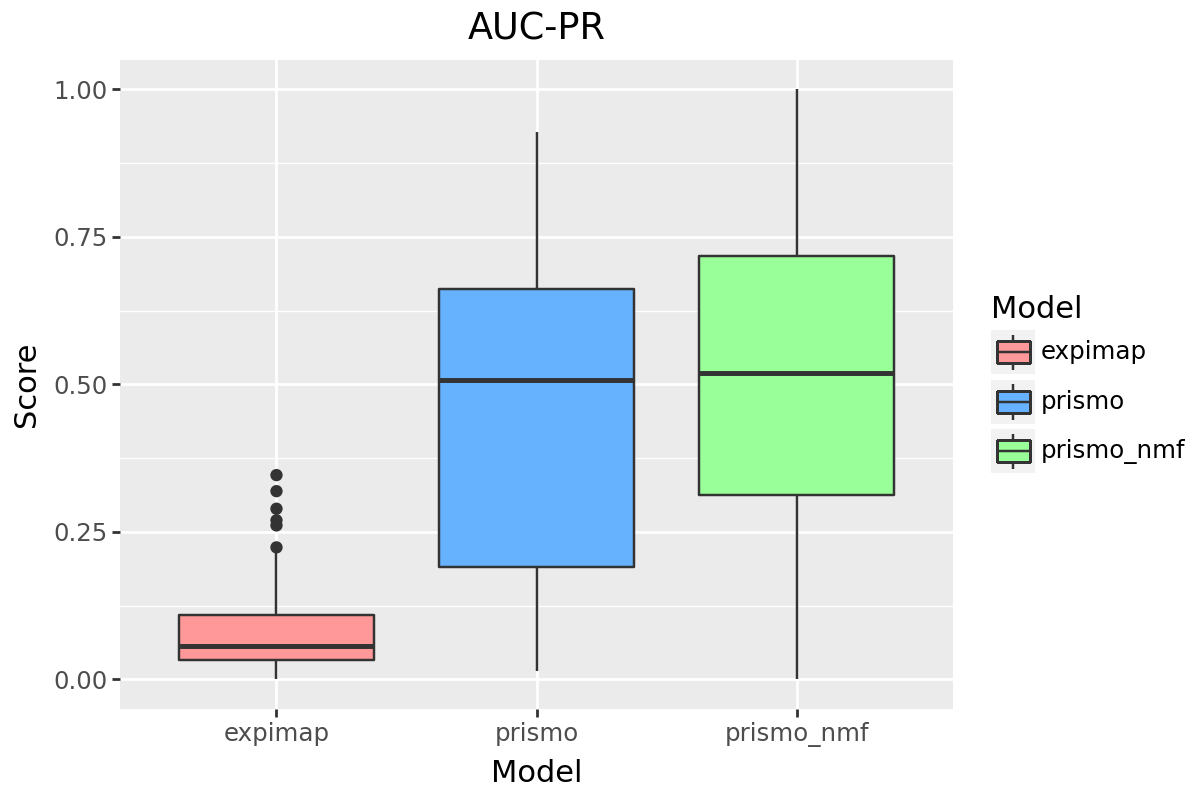

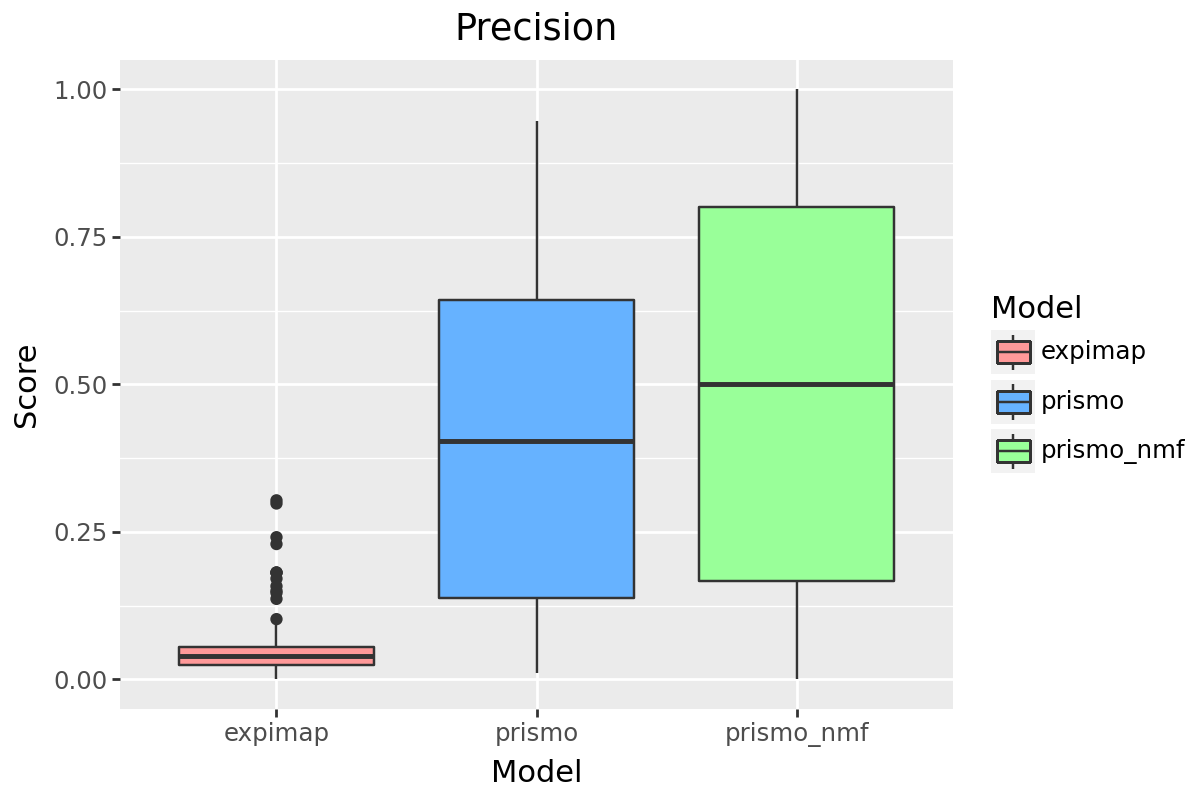

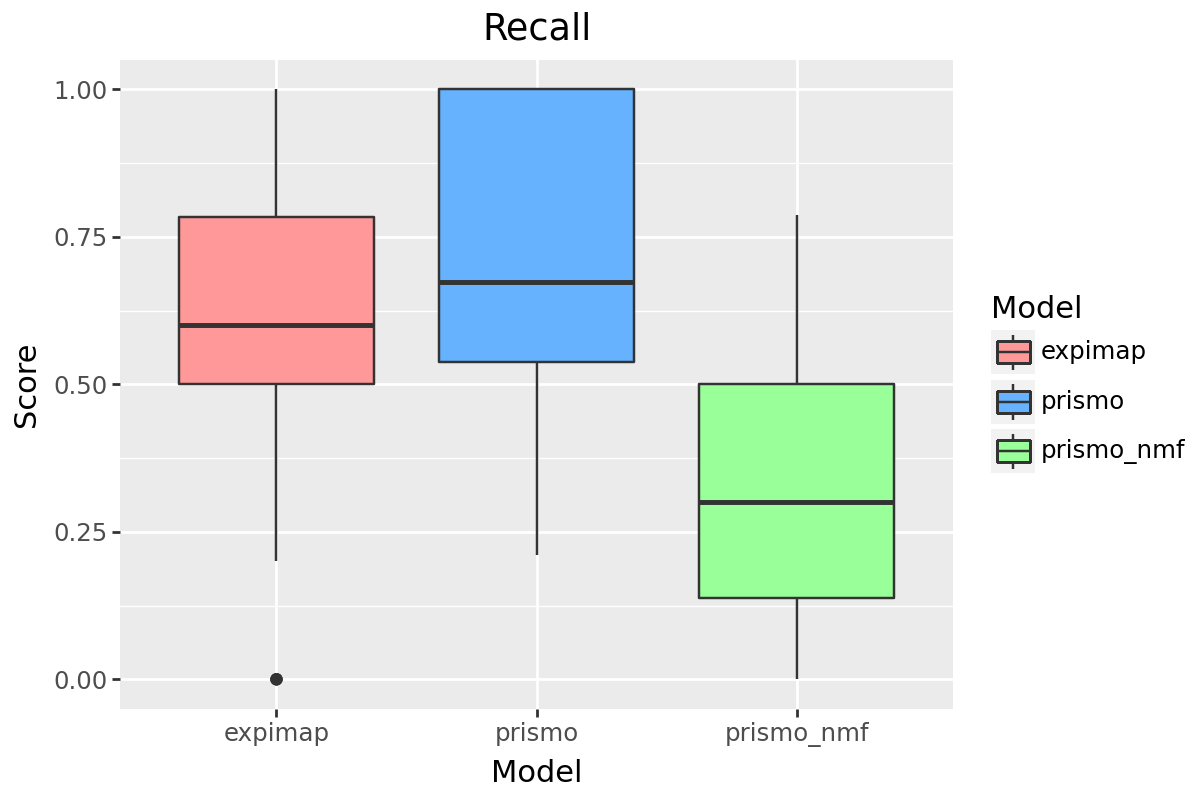

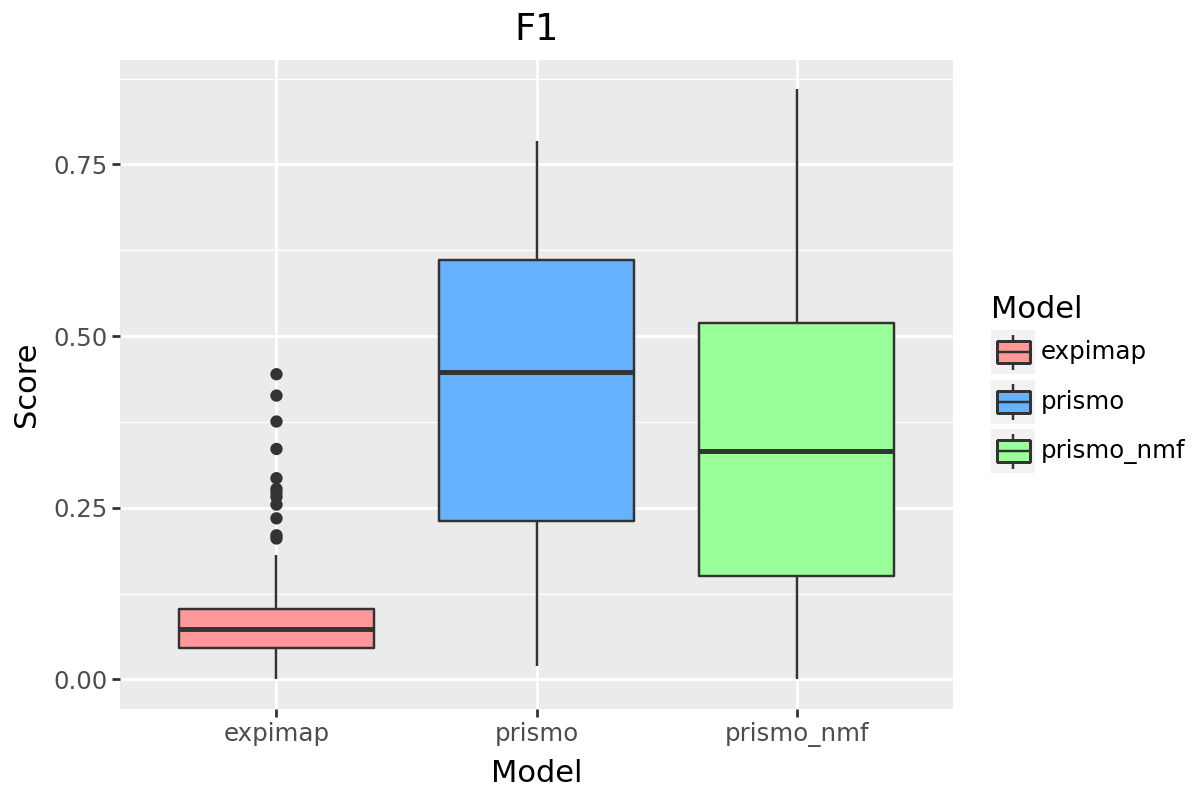

In [31]:
score_df_dict = {
    "AUC-PR": pd.DataFrame(per_factor_aupr),
    "Precision": pd.DataFrame(per_factor_prec),
    "Recall": pd.DataFrame(per_factor_rec),
    "F1": pd.DataFrame(per_factor_f1),
}

# for score_name, score_df in score_df_dict.items():
#     score_df.columns = [col.replace("_", " ") for col in score_df.columns]
#     # Do all capital
#     score_df.columns = [col.upper() for col in score_df.columns]

from plotnine import *
import pandas as pd


def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    for score_name, score_df in score_df_dict.items():
        if model_names is not None:
            score_df = score_df.loc[:, model_names]

        df_long = score_df.melt(var_name="Model", value_name="Score")
        df_long["Metric"] = score_name

        p = (
            ggplot(df_long, aes(x="Model", y="Score", fill="Model"))
            + geom_boxplot(**boxplot_kwargs)
            + labs(title=score_name)
            + scale_fill_manual(values=colors_disc[: len(score_df.columns)])
            + theme(axis_text_x=element_text(**xticklabels_kwargs), figure_size=(6, 4))
        )

        if ylim is not None:
            p = p + ylim(ylim[0], ylim[1])

        if model_labels is not None:
            p = p + scale_x_discrete(labels=model_labels)

        p.show()


plot_scores(score_df_dict)

In [32]:
score_df_dict["AUC-PR"].median()

expimap       0.055876
prismo        0.507756
prismo_nmf    0.519543
dtype: float64

In [33]:
model_scores = {}
for k, model in model_dict.items():
    model_scores[k] = []
    data_name = k.split("-")[0]
    if "expimap" in k:
        data_name = k.split("_")[0]

    data = data_dict[data_name]
    if "famo" in k:
        data = model.data["group_1"]["view_0"].X
    # model_scores[k].append(bm.get_rmse(model, model.data["group_1"]["view_0"].X))
    model_scores[k].append(bm.get_rmse(model, data))
    # model_scores[k].append(muvi.bm.get_average_precision(true_mask, model, top=200))
    model_scores[k].append(pd.DataFrame(per_factor_aupr).median()[k])
model_scores

{'expimap': [0.5311913, 0.05587620896962006],
 'prismo': [0.633013, 0.5077564397478702],
 'prismo_nmf': [0.55035436, 0.519543052544976]}

In [34]:
model_scores

{'expimap': [0.5311913, 0.05587620896962006],
 'prismo': [0.633013, 0.5077564397478702],
 'prismo_nmf': [0.55035436, 0.519543052544976]}

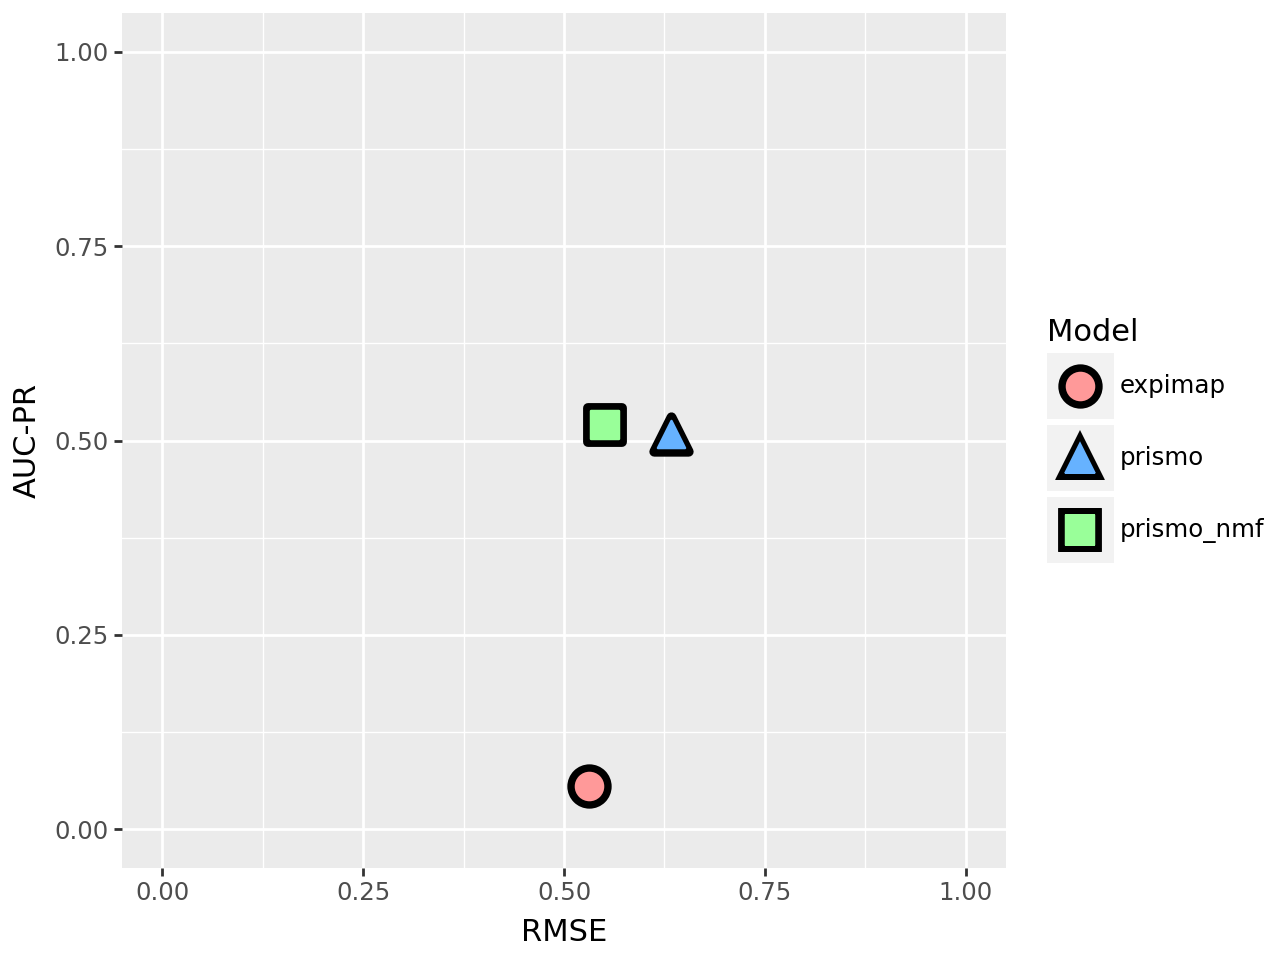

In [35]:
import pandas as pd
from plotnine import *

# Create a DataFrame
df = pd.DataFrame(model_scores).T.copy()
df.columns = ["RMSE", "AUC-PR"]
df["Model"] = df.index.copy()

# Create the plotnine plot
plot = (ggplot(df, aes(x="RMSE", y="AUC-PR", color="Model", shape="Model"))
 + geom_point(size=5, stroke=2, color="black", fill=None)
 + geom_point(size=5)
 + scale_color_manual(values=colors_disc)
 + xlim(0.0, 1.0)
 + ylim(0.0, 1.0)
 + theme(legend_position="right")
)
plot

In [36]:
def plot_scores(
    score_df_dict,
    model_names=None,
    model_labels=None,
    ylim=None,
    boxplot_kwargs={},
    xticklabels_kwargs={},
):
    fig, axs = plt.subplots(1, len(score_df_dict), figsize=(len(score_df_dict) * 3, 3))

    for ax, (score_name, score_df) in zip(axs, score_df_dict.items(), strict=False):
        if model_names is not None:
            score_df = score_df.loc[:, model_names]
        sns.boxplot(data=score_df, ax=ax, **boxplot_kwargs)
        ax.set_title(score_name)
        if ylim is not None:
            ax.set_ylim(*ylim)
        if model_labels is not None:
            ax.set_xticklabels(model_labels)
        ax.set_xticklabels(ax.get_xticklabels(), **xticklabels_kwargs)
    return fig, axs

In [37]:
model_dict.keys()

dict_keys(['expimap', 'prismo', 'prismo_nmf'])

/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'AUC-PR'}>,
        <Axes: title={'center': 'Precision'}>,
        <Axes: title={'center': 'Recall'}>, <Axes: title={'center': 'F1'}>],
       dtype=object))

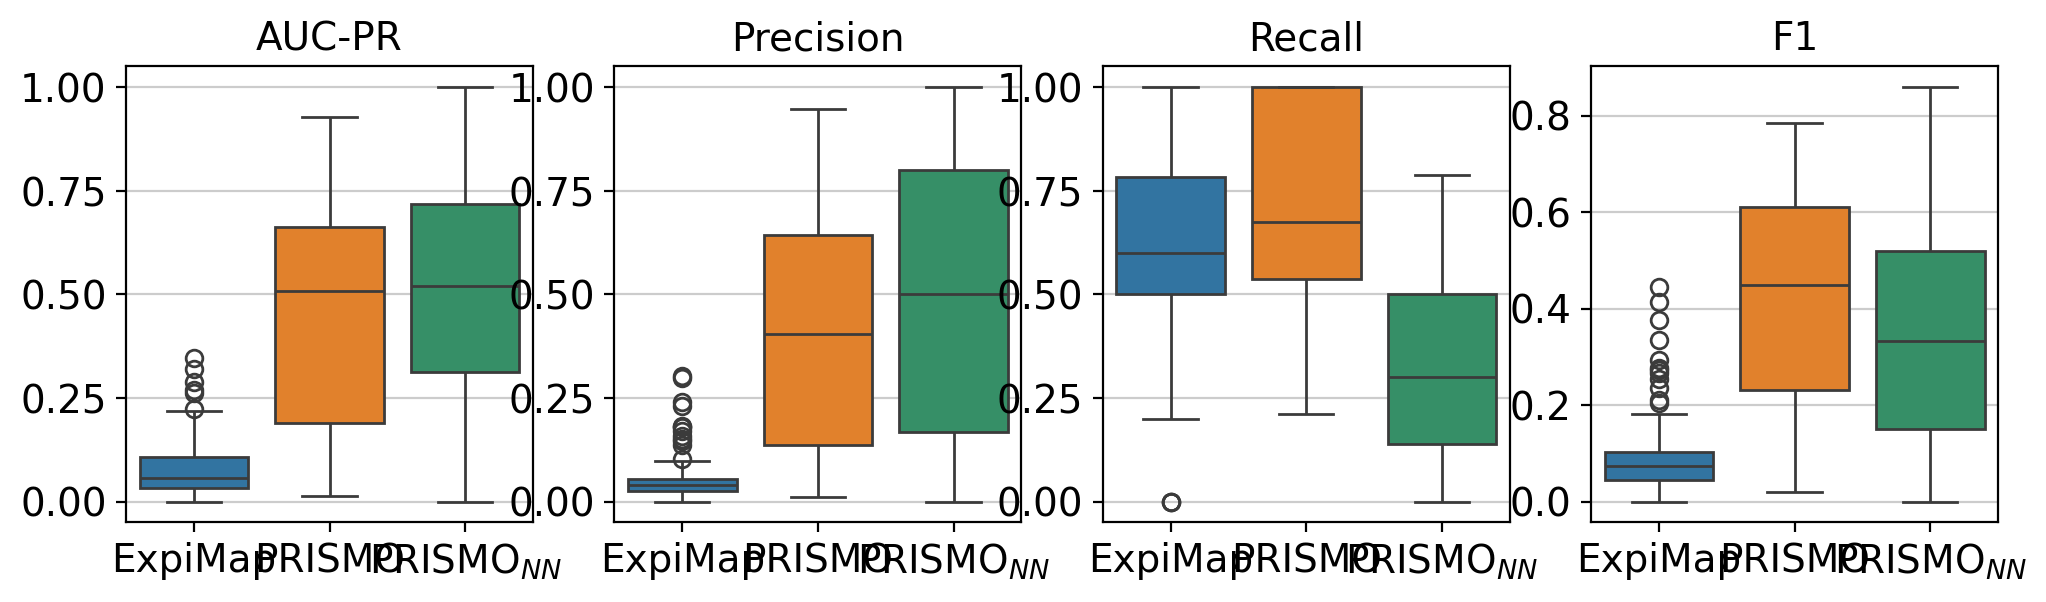

In [38]:
model_names = ["expimap", "spectra", "prismo", "prismo_nmf"]
model_labels = ["ExpiMap", "Spectra", "PRISMO", "PRISMO$_{NN}$"]

model_names = ["expimap", "prismo", "prismo_nmf"]
model_labels = ["ExpiMap", "PRISMO", "PRISMO$_{NN}$"]

# model_names = ["expimap", "spectra", "muvi_nmf"]
# model_labels = ["ExpiMap", "Spectra", "MuVI+"]

# model_names = ["muvi", "famo"]
# model_labels = ["MuVI", "FAMO"]

plot_scores(score_df_dict, model_names, model_labels)

In [39]:
# top_factor_indices = set(list(range(len(terms))))
# for k, model in model_dict.items():
#     top_factors = sorted(
#         muvi.bm.get_top_factors(model, data_dict[k.split("-")[0]], r2_thresh=0.95)[0]
#     )
#     print(k, top_factors)
#     top_factor_indices &= set(top_factors)
# top_factor_indices

In [40]:
# top_factor_indices = list(range(n_informative_factors - start_factor_idx))
# top_factor_indices

In [41]:
# score_df_dict = {
#     "aupr": pd.DataFrame(per_factor_aupr),
#     "prec": pd.DataFrame(per_factor_prec),
#     "rec": pd.DataFrame(per_factor_rec),
#     "f1": pd.DataFrame(per_factor_f1),
# }
# score_df_dict = {
#     k: v.iloc[sorted(top_factor_indices), :] for k, v in score_df_dict.items()
# }
# plot_scores(score_df_dict, model_names, model_labels)

In [42]:
# pd.DataFrame(per_factor_aupr).sort_values("muvi_nmf")

In [43]:
factor_loadings = {k: bm.get_factor_loadings(model) for k, model in model_dict.items()}
factor_loadings.keys()

dict_keys(['expimap', 'prismo', 'prismo_nmf'])

In [44]:
# for i, t in enumerate(terms):
#     if 'interferon'.upper() in t.upper():
#         for mn, fl in factor_loadings.items():
#             print(mn)
#             g, _ = muvi.pl.factor_activity(
#                 fl, fl, true_mask=true_mask, noisy_mask=noisy_mask, factor_idx=i, top=200
#             )
#             g.set_title(f"{t}: {mn}")
#             plt.show()

In [45]:
# for mn, fl in factor_loadings.items():
#     print(mn)
#     muvi.pl.factor_activity(fl, fl, true_mask=true_mask, noisy_mask=noisy_mask, factor_idx=7, top=200)
#     plt.show()

In [46]:
fn_sum = (true_mask & ~noisy_mask).sum(axis=1)

In [47]:
np.set_printoptions(precision=1)

In [48]:
idx_df = {}
tp_df = {}
tn_df = {}
fp_df = {}
fn_df = {}
for k, model in model_dict.items():
    idx, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    idx_df[k] = idx
    non_zero = np.abs(wh) > 0.0
    tp = tm & nm & non_zero
    tn = ~tm & ~nm & non_zero
    fp = ~tm & nm & non_zero
    fn = tm & ~nm & non_zero
    tp_df[k] = tp.sum(axis=1).tolist()
    tn_df[k] = tn.sum(axis=1).tolist()
    fp_df[k] = fp.sum(axis=1).tolist()
    fn_df[k] = fn.sum(axis=1).tolist()
    if len(k) < 5:
        k += "\t"
    print(
        k,
        "\t",
        "TP, FP, TN, FN",
        "\t",
        f"{tp.sum(axis=1).mean():2.2f}, {fp.sum(axis=1).mean():2.2f}, {tn.sum(axis=1).mean():2.2f}, {fn.sum(axis=1).mean():2.2f}",
    )
    # print("FN", k[:4], fn.sum(), "\t", fn.sum(axis=1).tolist() / fn_sum)
    # term_idx = 7
    # print(k[:4], set(idx[term_idx, :]) & set(top_overlap_dict[terms[term_idx]]))
    # break
tp_df = pd.DataFrame(tp_df)
tn_df = pd.DataFrame(tn_df)
fp_df = pd.DataFrame(fp_df)
fn_df = pd.DataFrame(fn_df)

expimap 	 TP, FP, TN, FN 	 6.83, 0.80, 189.58, 2.78
prismo 	 TP, FP, TN, FN 	 28.82, 7.88, 161.00, 2.31
prismo_nmf 	 TP, FP, TN, FN 	 13.56, 1.92, 181.46, 3.07


/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/tmp/ipykernel_4002329/1909159686.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'True Positive'}>,
        <Axes: title={'center': 'True Negative'}>,
        <Axes: title={'center': 'False Positive'}>,
        <Axes: title={'center': 'False Negative'}>], dtype=object))

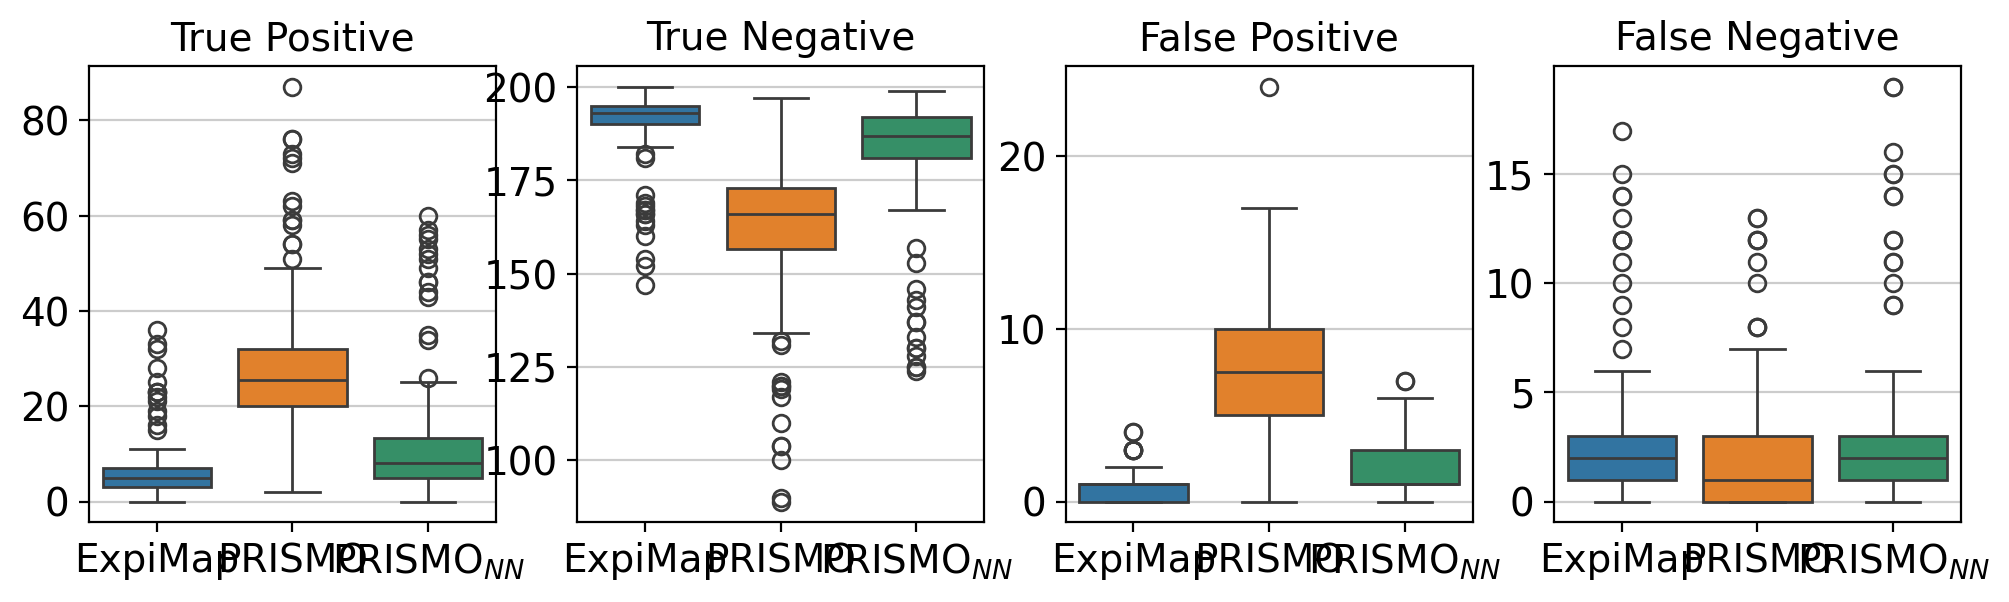

In [49]:
plot_scores(
    {
        "True Positive": tp_df,
        "True Negative": tn_df,
        "False Positive": fp_df,
        "False Negative": fn_df,
    },
    model_names,
    model_labels,
)
# plot_scores(
#     {"False Positive": fp_df, "False Negative": fn_df}, model_names, model_labels
# )

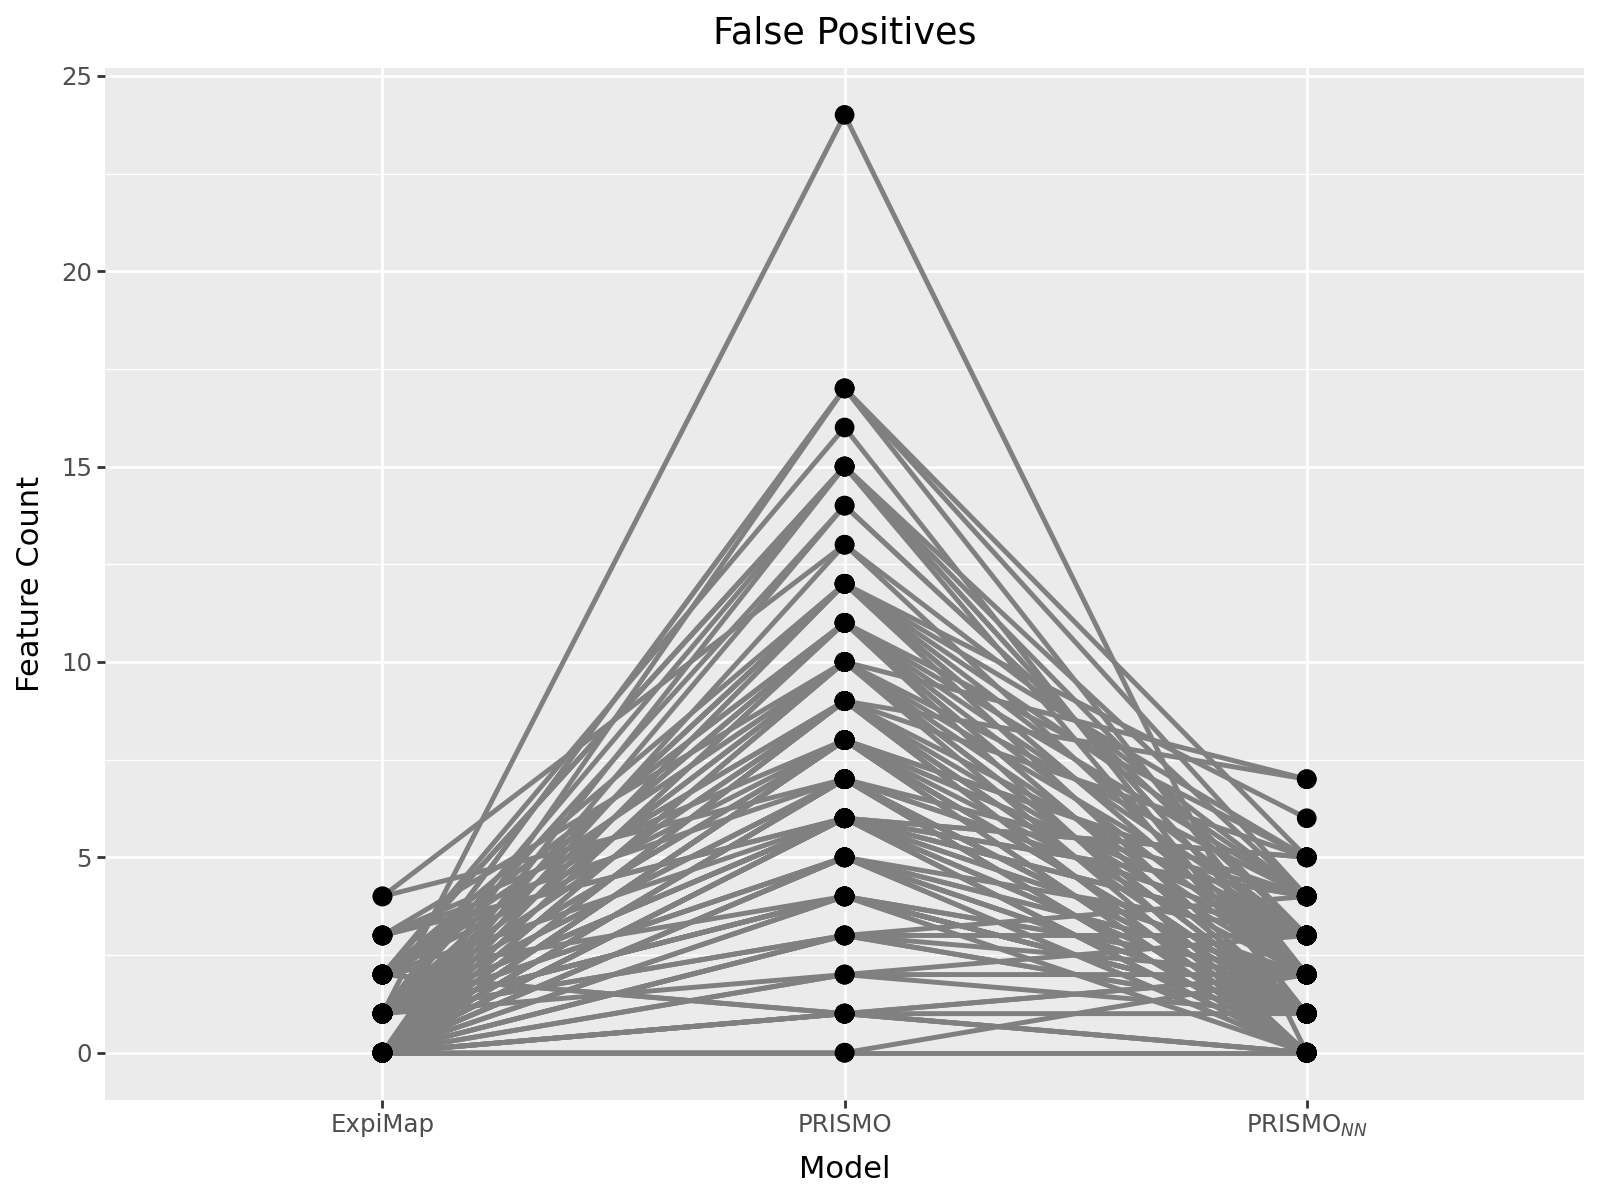

In [50]:
# model_cols = ["expimap", "spectra", "muvi", "muvi_nmf"]
# point_df = fp_df[model_cols].copy()
# model_cols = ["ExpiMap", "Spectra", "MuVI", "MuVI$_{NN}$"]
 
model_cols = model_names
point_df = fp_df[model_cols].copy()
model_cols = model_labels

# model_cols = ["spectra", "famo", "famo_nmf"]
# point_df = fp_df[model_cols].copy()
# # point_df = fn_df[model_cols].copy()
# model_cols = ["Spectra", "FAMO", "FAMO$_{NN}$"]

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(ggplot(point_df, aes(x='Model', y='Feature Count', group='factor'))
 + geom_line(alpha=1.0, color='gray', size=1)
 + geom_point(alpha=1.0, color='black', size=3)
 + ggtitle("False Positives")
 + theme(figure_size=(8, 6))
)


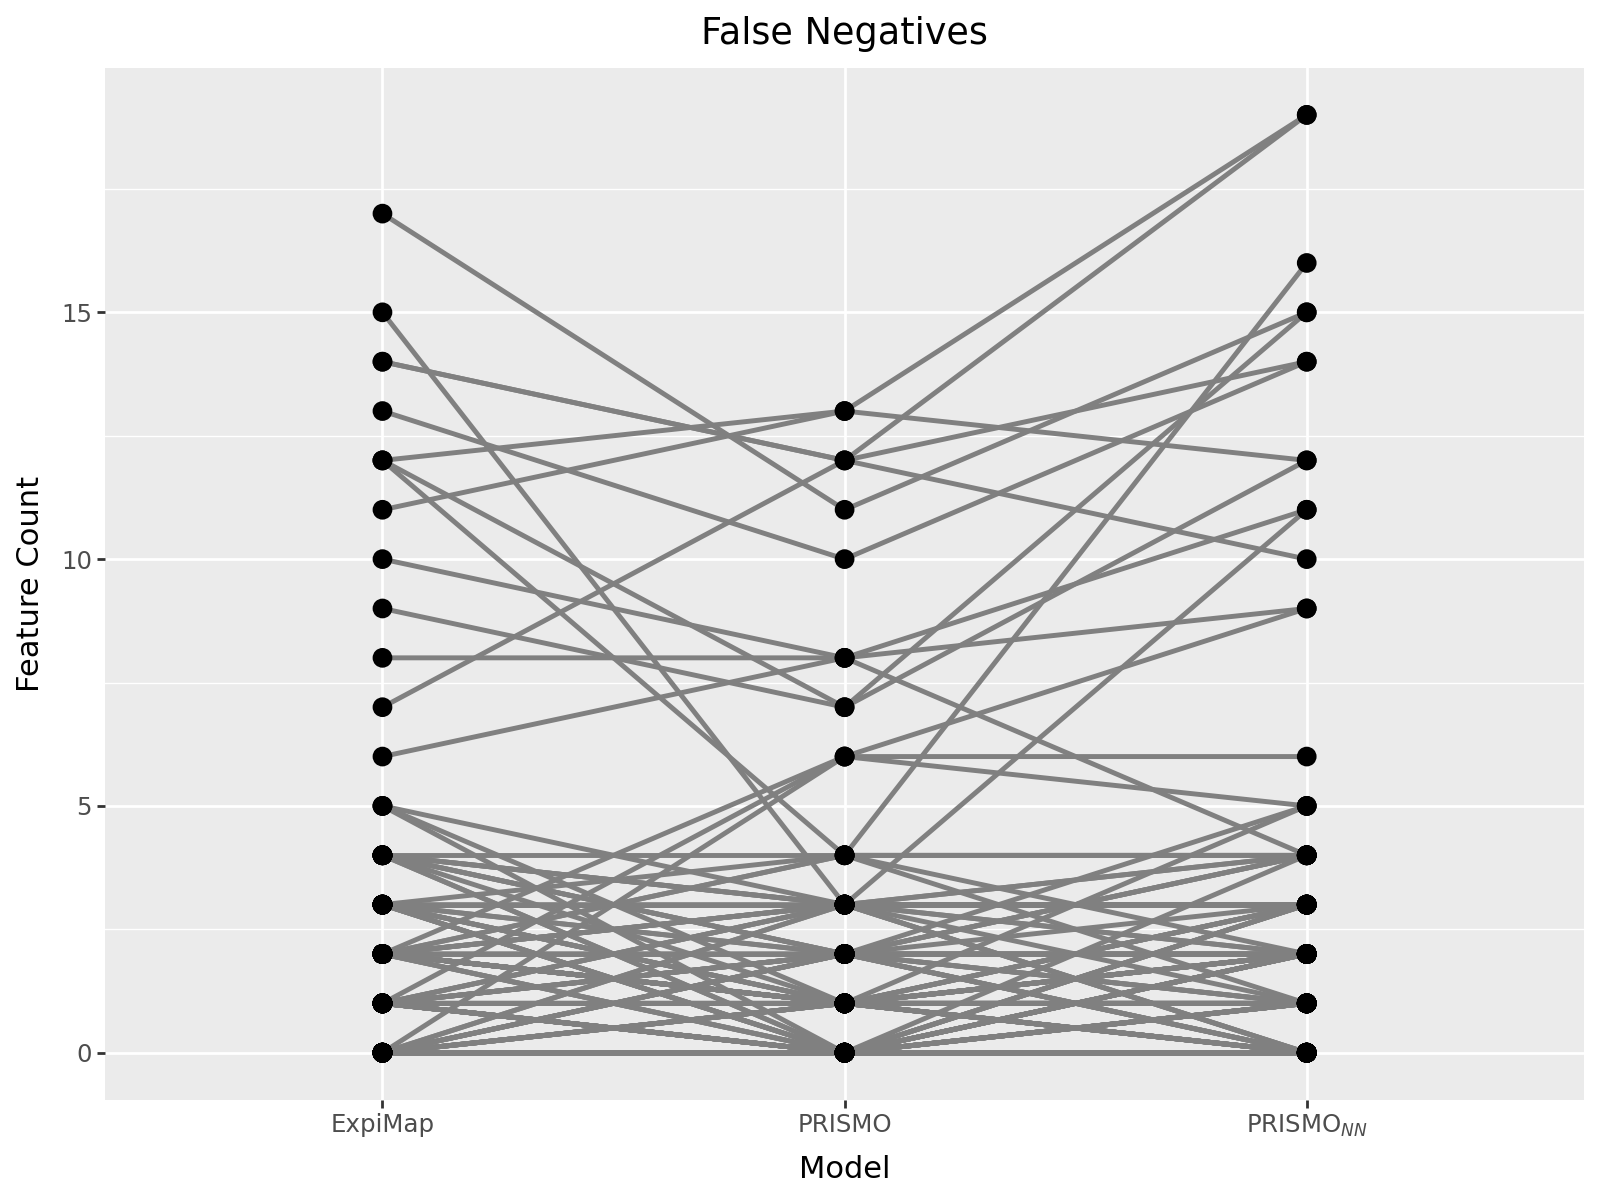

In [51]:
# model_cols = ["expimap", "spectra", "muvi", "muvi_nmf"]
# point_df = fp_df[model_cols].copy()
# model_cols = ["ExpiMap", "Spectra", "MuVI", "MuVI$_{NN}$"]

model_cols = model_names
point_df = fn_df[model_cols].copy()
model_cols = model_labels

# model_cols = ["spectra", "famo", "famo_nmf"]
# # point_df = fp_df[model_cols].copy()
# point_df = fn_df[model_cols].copy()
# model_cols = ["Spectra", "FAMO", "FAMO$_{NN}$"]

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(ggplot(point_df, aes(x='Model', y='Feature Count', group='factor'))
 + geom_line(alpha=1.0, color='gray', size=1)
 + geom_point(alpha=1.0, color='black', size=3)
 + ggtitle("False Negatives")
 + theme(figure_size=(8, 6))
)


In [52]:
# pd.DataFrame(per_factor_aupr, index=terms).sort_values('muvi_nmf', ascending=False).iloc[:20, :]
# muvi.pl.inspect_factor(model_dict['muvi_nmf'], 49)
# [(i, t) for i, t in enumerate(terms) if "INTERFERON" in t]

In [53]:
# from sklearn.metrics import PrecisionRecallDisplay

In [54]:
# factor_idx = 51
# top=200
# for k, model in model_dict.items():
#     idx, wh, tm, nm = muvi.bm.get_reconstruction_fraction(
#         true_mask, noisy_mask, model, top=top
#     )
#     display = PrecisionRecallDisplay.from_predictions(tm[factor_idx, :], wh[factor_idx, :], name=k)
#     _ = display.ax_.set_title("2-class Precision-Recall curve")

# plt.show()

In [55]:
# # top_overlap_dict = {}
# for k in range(true_mask.shape[0]):
#     d = None
#     for mn, v in idx_df.items():
#         if 'muvi' in mn:
#             continue
#         s = set(v[k, :40])
#         if d is None:
#             d = s
#         else:
#             d &= s
#     print(terms[k], d)
#     # top_overlap_dict[terms[k]] = d

In [56]:
for top in [50, 100, 200, 500]:
    top_overlap_dict = {}
    for k in range(true_mask.shape[0]):
        d = None
        for mn, v in idx_df.items():
            if "nmf" in mn:
                continue
            s = set(v[k, :top])
            if d is None:
                d = s
            else:
                d &= s
        # print(terms[k], d)
        top_overlap_dict[terms[k]] = adata.var_names[sorted(d)]
    print("DONE")
    # muvi.fs.from_dict(top_overlap_dict).to_gmt(f'top_overlap_dict_at_{top}.gmt')

DONE
DONE
DONE
DONE


In [57]:
[(i, t) for i, t in enumerate(terms) if "INTERFERON" in t]

[(26, 'REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA'),
 (49, 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'),
 (50, 'REACTOME_INTERFERON_GAMMA_SIGNALING'),
 (51, 'REACTOME_INTERFERON_SIGNALING')]

In [58]:
[(i, t) for i, t in enumerate(terms) if "B_CELL" in t]

[(34, 'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'),
 (99, 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR')]

In [59]:
pd.DataFrame(per_factor_aupr).loc[[49, 50, 51], :]

expimap    prismo  prismo_nmf
49  0.053520  0.547618    0.525659
50  0.045300  0.100355    0.537274
51  0.289221  0.544703    0.441725

In [60]:
pd.DataFrame(per_factor_aupr).loc[[99], :]

expimap    prismo  prismo_nmf
99  0.042072  0.147113     0.18183

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
# adata_og = ad.read_h5ad("../data/kang_tutorial.h5ad").copy()
# adata_og = ad.read_h5ad("../../../../data/muvi/kang_tutorial.h5ad").copy()

In [63]:
# model_name = "muvi_nmf"
# data_name = model_name.split("_")[0]
# factor_idx = 49
# factor_name = "Interferon Alpha Beta Signaling"
# adata.obs = adata_og.obs.loc[adata.obs_names, :].copy()
# adata.obs[factor_name] = muvi.bm.get_factor_scores(
#     model_dict[model_name], data_dict[data_name]
# )[:, factor_idx]
# adata.obs
# print("ROC:", roc_auc_score(adata.obs["condition"], adata.obs[factor_name]))
# sns.stripplot(data=adata.obs, x="condition", y=factor_name, hue="condition", s=2)

In [64]:
# model_name = "muvi_nmf"
# factor_idx = [49, 51]
# factor_name = ["Interferon Alpha Beta Signaling", "Interferon Signaling"]
# adata.obs = adata_og.obs.loc[adata.obs_names, :].copy()
# adata.obs["Condition"] = adata.obs["condition"]
# for k, fn in enumerate(factor_name):
#     adata.obs[fn] = muvi.bm.get_factor_scores(
#         model_dict[model_name], data_dict[model_name]
#     )[:, factor_idx[k]]
# adata.obs
# # print("ROC:", roc_auc_score(adata.obs['condition'], adata.obs[factor_name]))
# sns.scatterplot(
#     data=adata.obs, x=factor_name[0], y=factor_name[1], hue="Condition", s=2
# )

In [65]:
# adata_og.obs["cell_type"]

In [66]:
# adata.obs["Cell Type"] = adata_og.obs["cell_type"].copy()
# adata.obs["cell_type"] = adata_og.obs["cell_type"].copy()

In [67]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "INTERFERON" in t]

[(29, 'REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA'),
 (52, 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'),
 (53, 'REACTOME_INTERFERON_GAMMA_SIGNALING'),
 (54, 'REACTOME_INTERFERON_SIGNALING')]

In [68]:
[(i, t) for i, t in enumerate(model_dict[model_name].factor_names) if "B_CELL" in t]

[(37, 'REACTOME_DOWNSTREAM_SIGNALING_EVENTS_OF_B_CELL_RECEPTOR_BCR'),
 (102, 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR')]

ROC: 0.4129212668012083


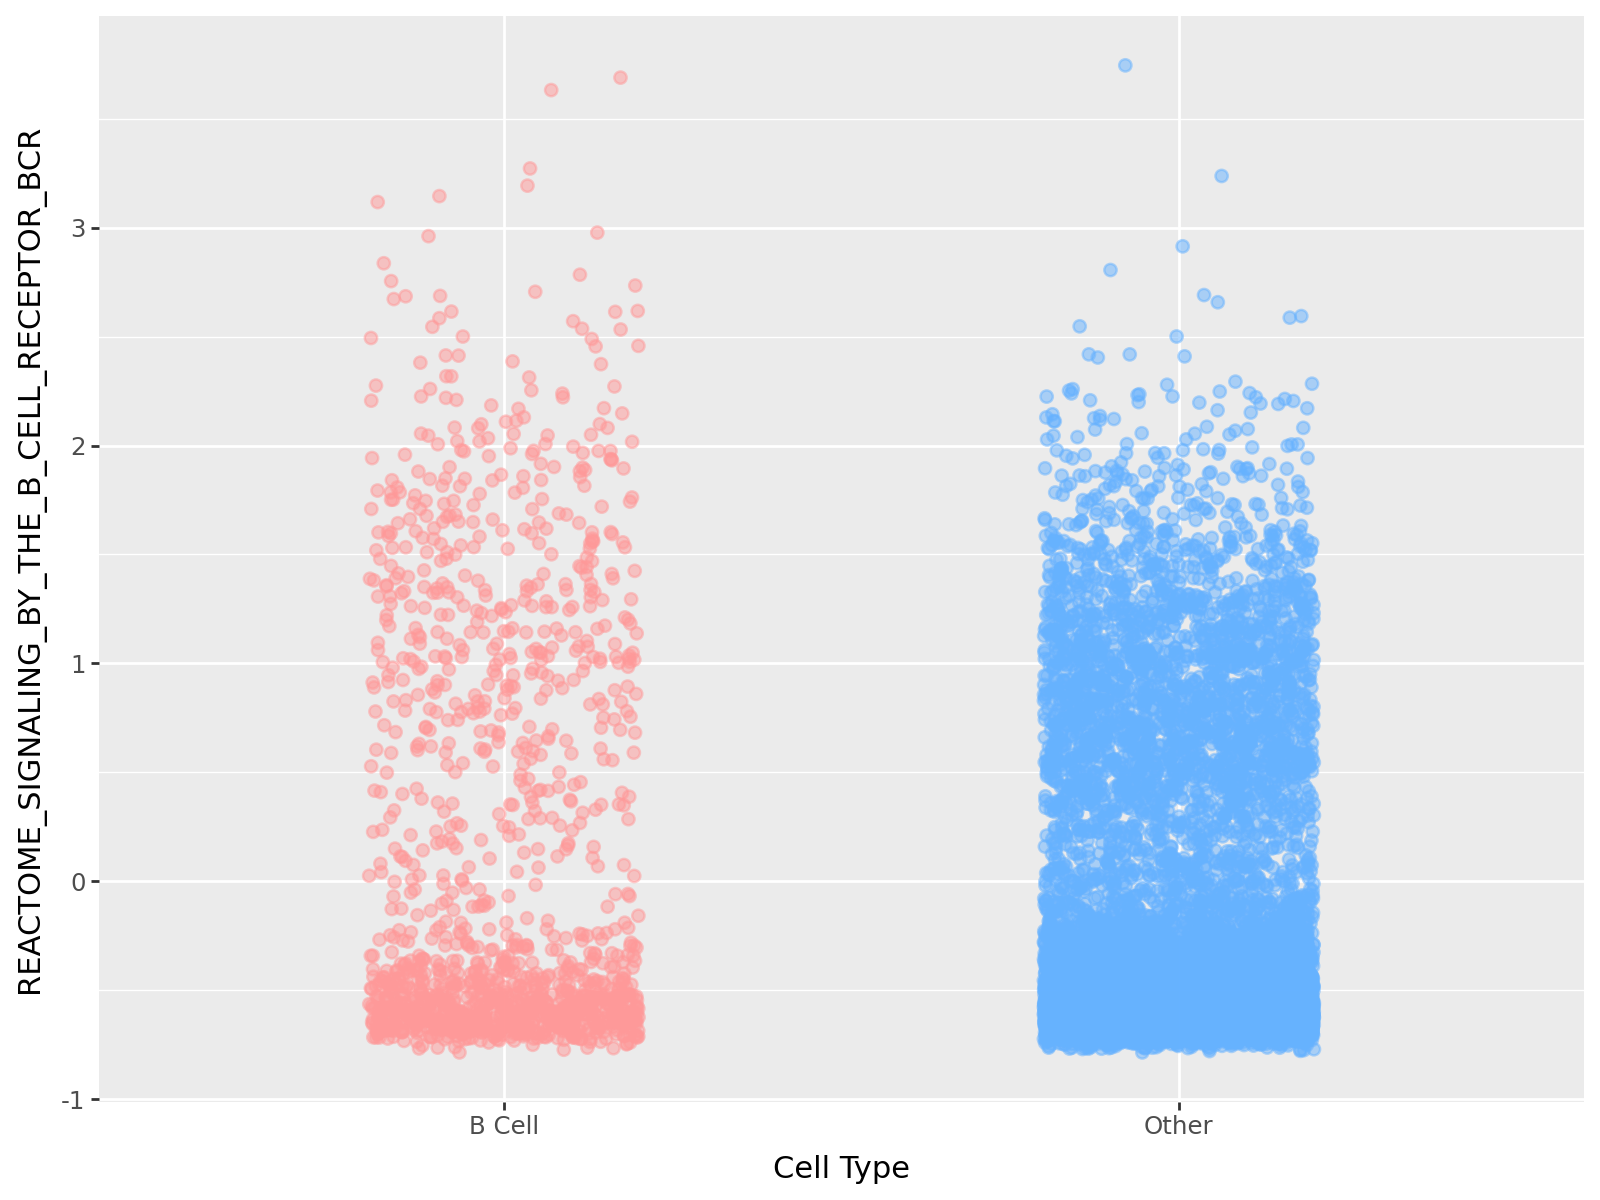

In [69]:
model_name = "prismo"
factor_name = "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
adata.obs
adata.obs["Cell Type"] = "Other"
adata.obs.loc[adata.obs["cell_type"] == "B", "Cell Type"] = "B Cell"
print("ROC:", roc_auc_score(adata.obs["Cell Type"], adata.obs[factor_name]))

(ggplot(adata.obs, aes(x='Cell Type', y=factor_name, color='Cell Type'))
 + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
 + scale_color_manual(values={'B Cell': colors_disc[0], 'Other': colors_disc[1]})
 + scale_x_discrete(limits=['B Cell', 'Other'])
 + theme(
     figure_size=(8, 6),
     legend_position='none'
 )
)


ROC: 0.011655549443015188


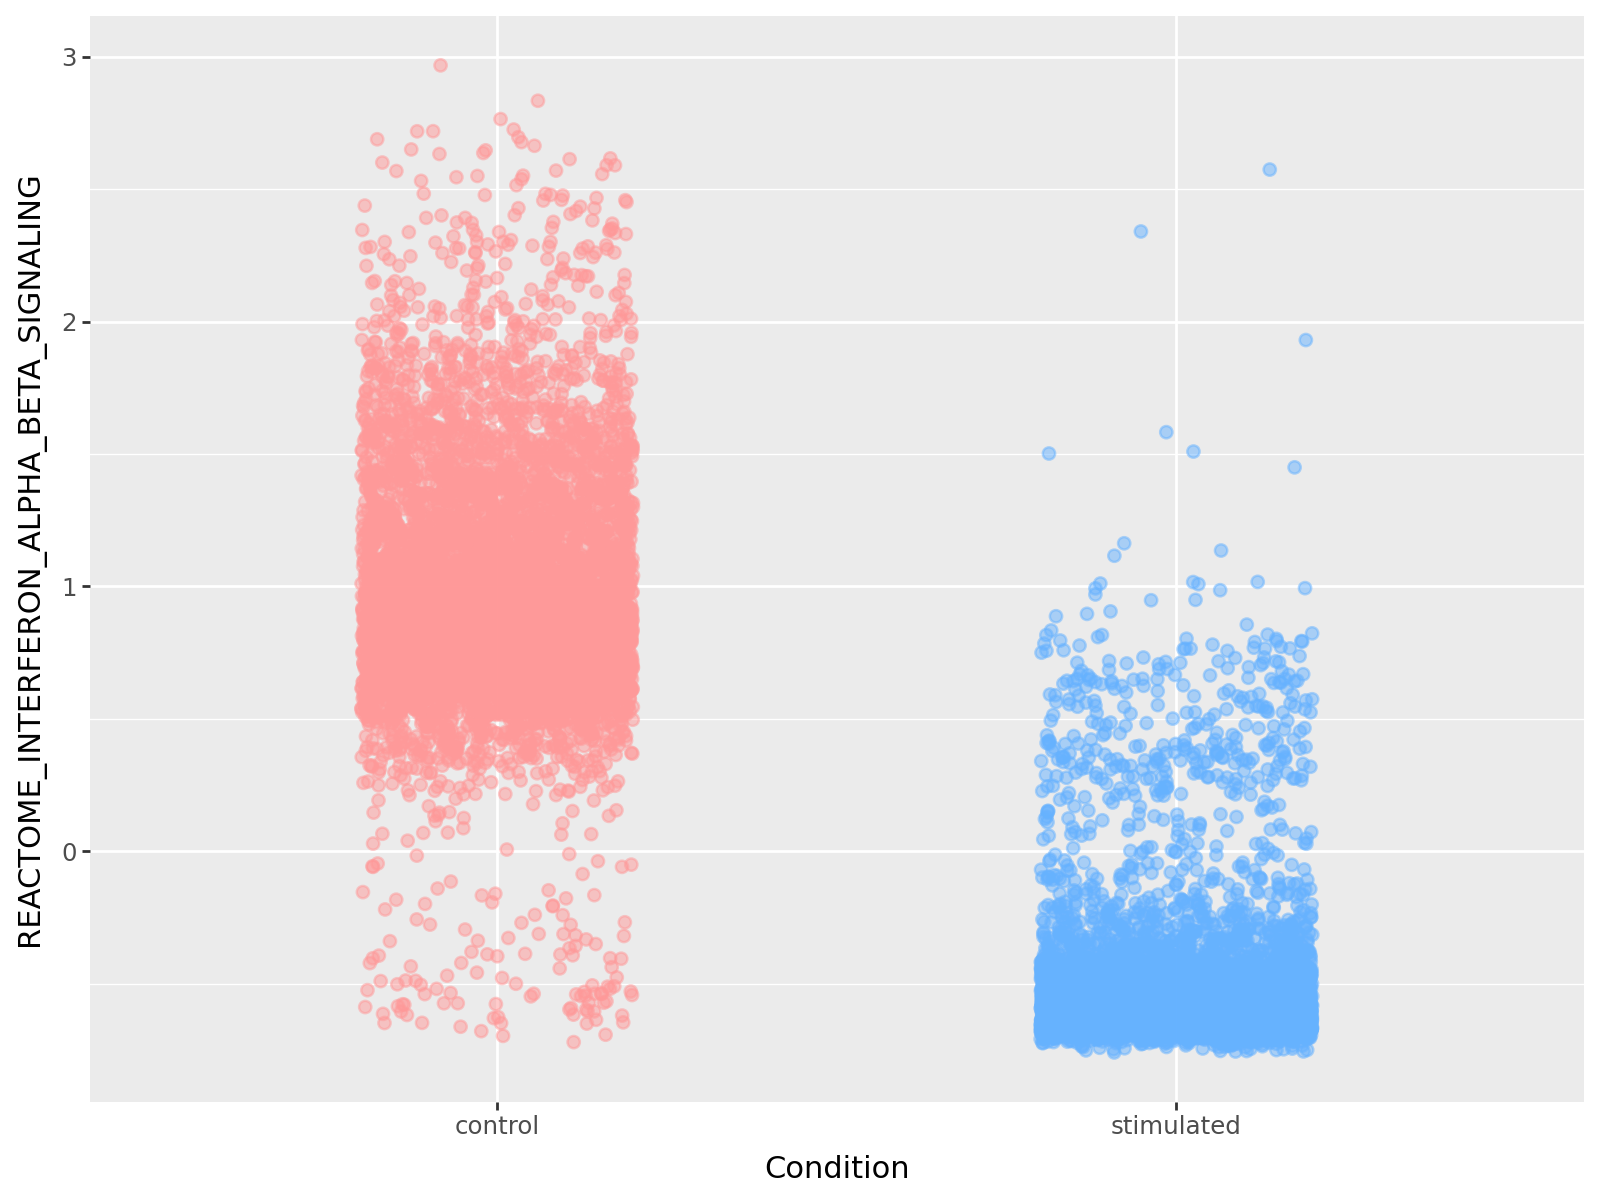

In [70]:
model_name = "prismo"
factor_name = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"
adata.obs[factor_name] = (
    model_dict[model_name].get_factors()["group_1"].loc[:, factor_name]
)
print("ROC:", roc_auc_score(adata.obs["condition"], adata.obs[factor_name]))

(ggplot(adata.obs, aes(x='condition', y=factor_name, color='condition'))
 + geom_jitter(alpha=0.5, size=2, width=0.2, height=0)
 + scale_color_manual(values={'control': colors_disc[0], 'stimulated': colors_disc[1]})
 + theme(
     figure_size=(8, 6),
     legend_position='none',
 )
 + labs(x='Condition', y=factor_name)
)


In [71]:
prismo_model = model_dict["prismo"]

In [72]:
adata_latent = prismo_model.get_factors("anndata")["group_1"].copy()
adata_latent.obs = adata.obs.copy()
obs_names = adata_latent.obs_names.to_numpy()
# np.random.shuffle(obs_names)
adata_latent = adata_latent[obs_names, :].copy()
adata_latent

AnnData object with n_obs × n_vars = 13576 × 123
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR', 'Cell Type', 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'

In [73]:
import scanpy as sc

In [74]:
sc.pp.neighbors(adata_latent, use_rep="X")

In [75]:
sc.tl.leiden(adata_latent)

/tmp/ipykernel_4002329/1109381367.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [76]:
sc.tl.umap(adata_latent)

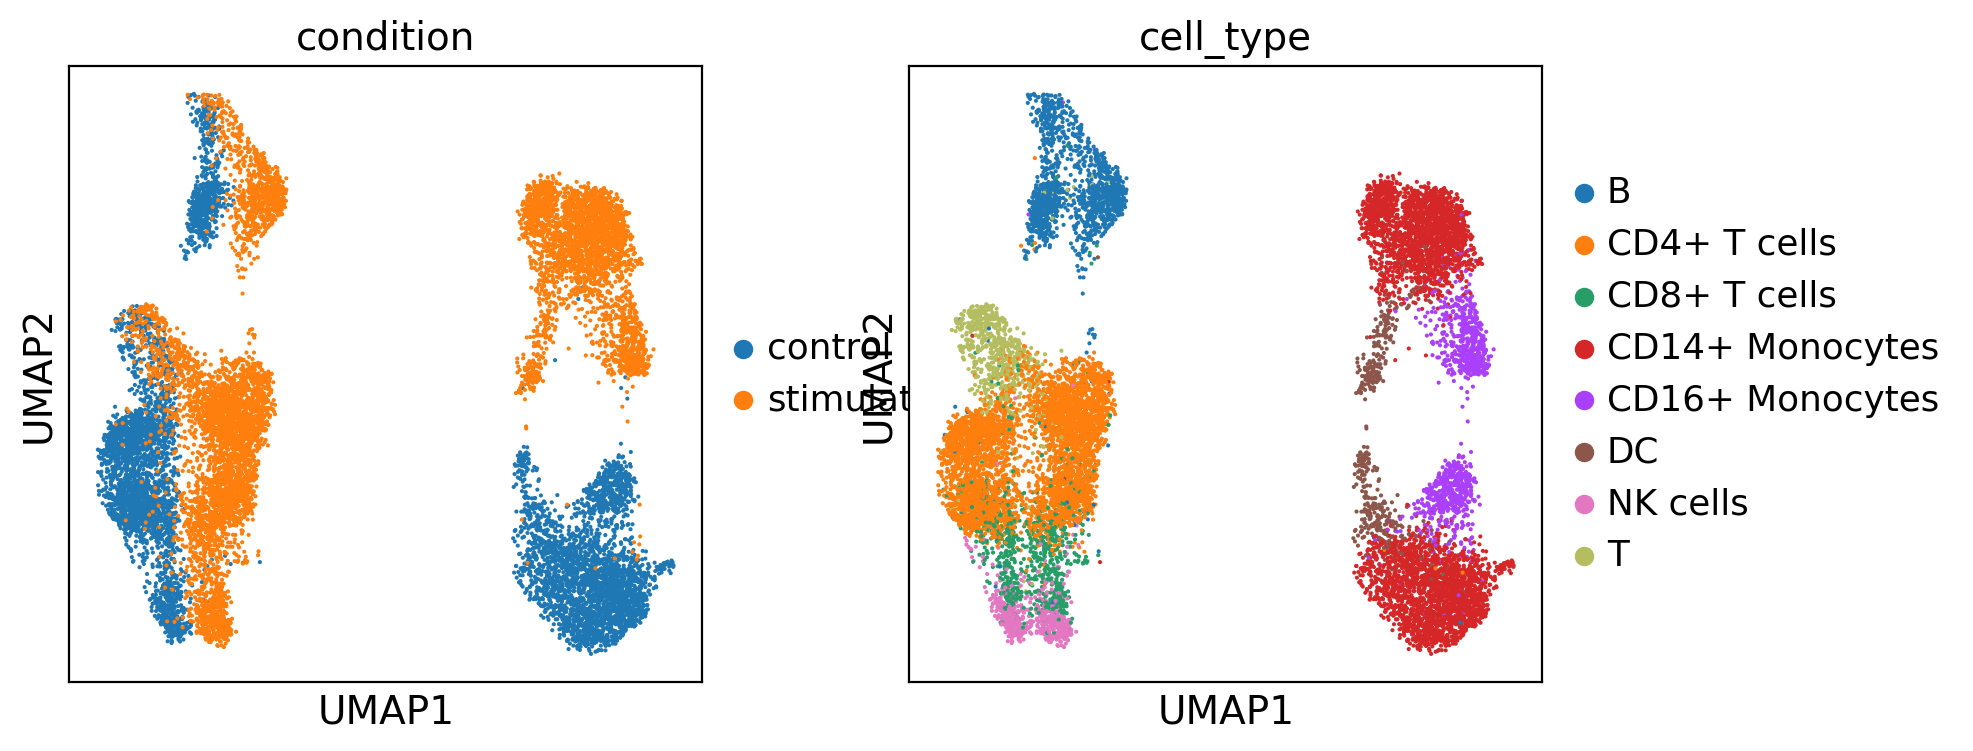

In [77]:
sc.pl.umap(adata_latent, color=["condition", "cell_type"])

In [78]:
sc.tl.rank_genes_groups(adata_latent, groupby="condition")

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2


In [79]:
del adata_latent.obs["REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"]
del adata_latent.obs["REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"]

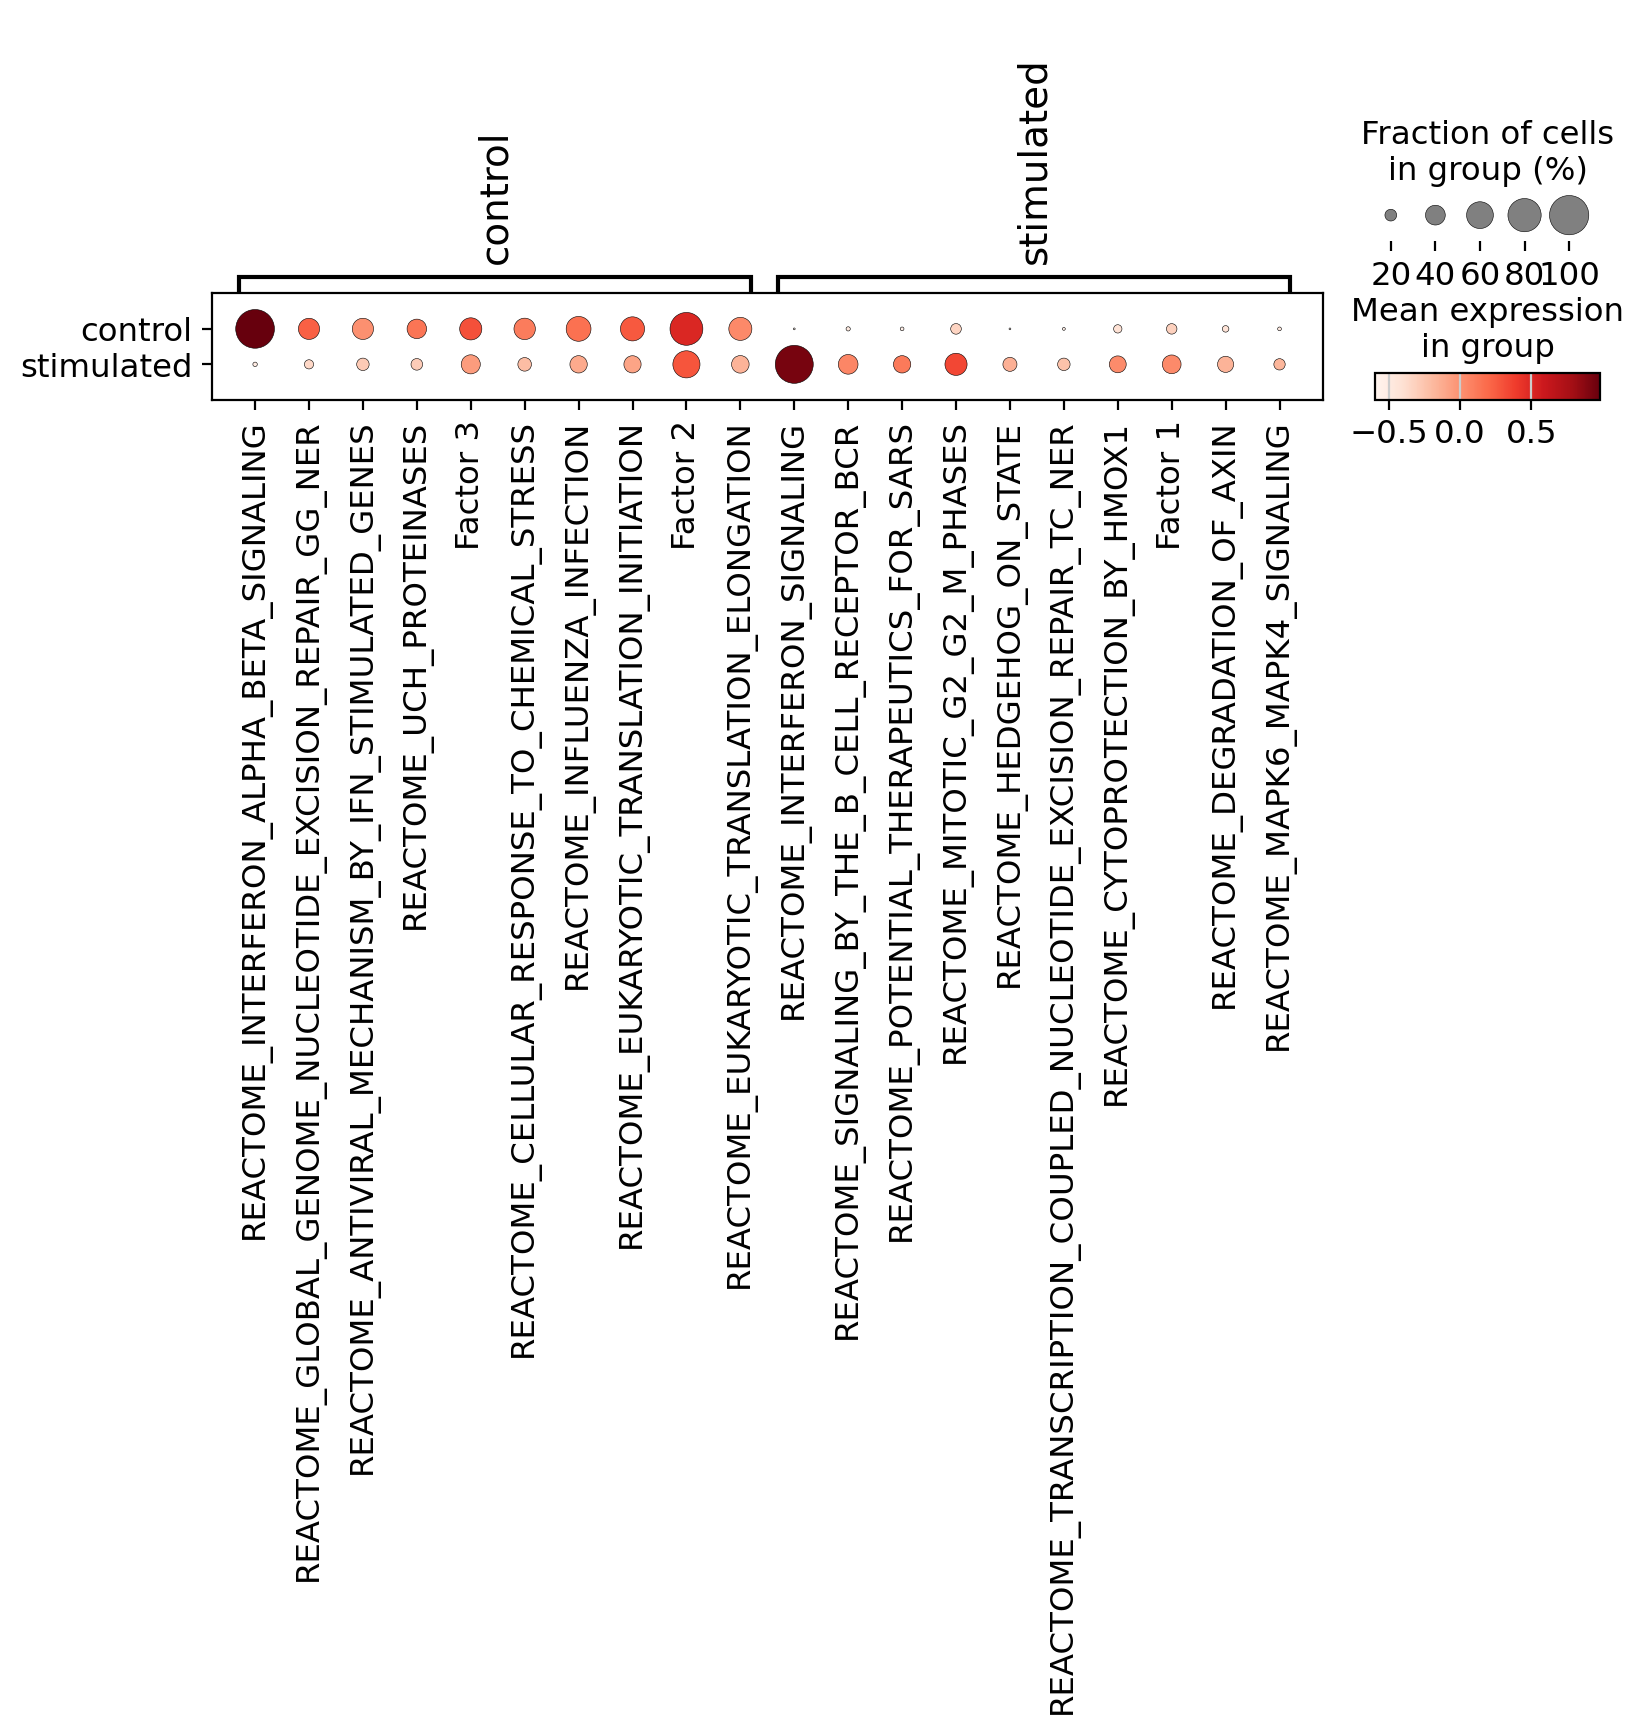

In [80]:
sc.pl.rank_genes_groups_dotplot(adata_latent)

In [81]:
adata_latent

AnnData object with n_obs × n_vars = 13576 × 123
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'Cell Type', 'leiden'
    uns: 'neighbors', 'leiden', 'umap', 'condition_colors', 'cell_type_colors', 'rank_genes_groups'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [82]:
# sc.pl.scatter(adata_latent, x="Factor 1", y="Factor 3", color="condition")

In [83]:
[vn for vn in adata_latent.var_names if "INTERFER" in vn]

['REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA',
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
 'REACTOME_INTERFERON_GAMMA_SIGNALING',
 'REACTOME_INTERFERON_SIGNALING']

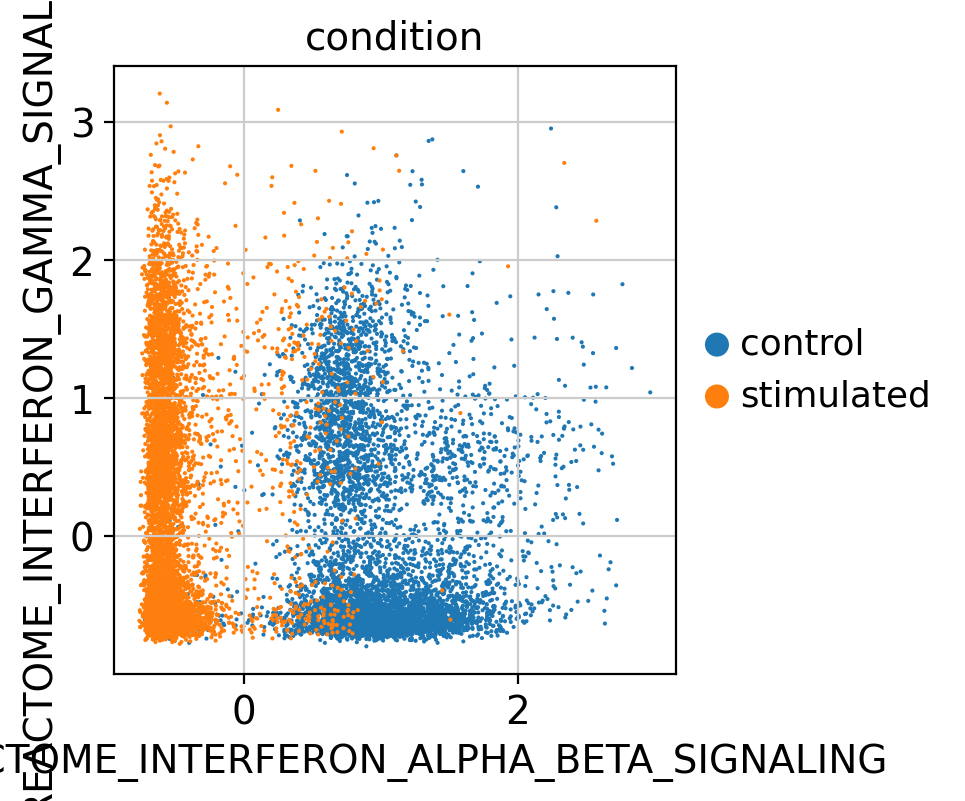

In [84]:
sc.pl.scatter(
    adata_latent,
    x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    y="REACTOME_INTERFERON_GAMMA_SIGNALING",
    color="condition",
)

In [85]:
from prismo import plotting

In [86]:
import plotting

(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

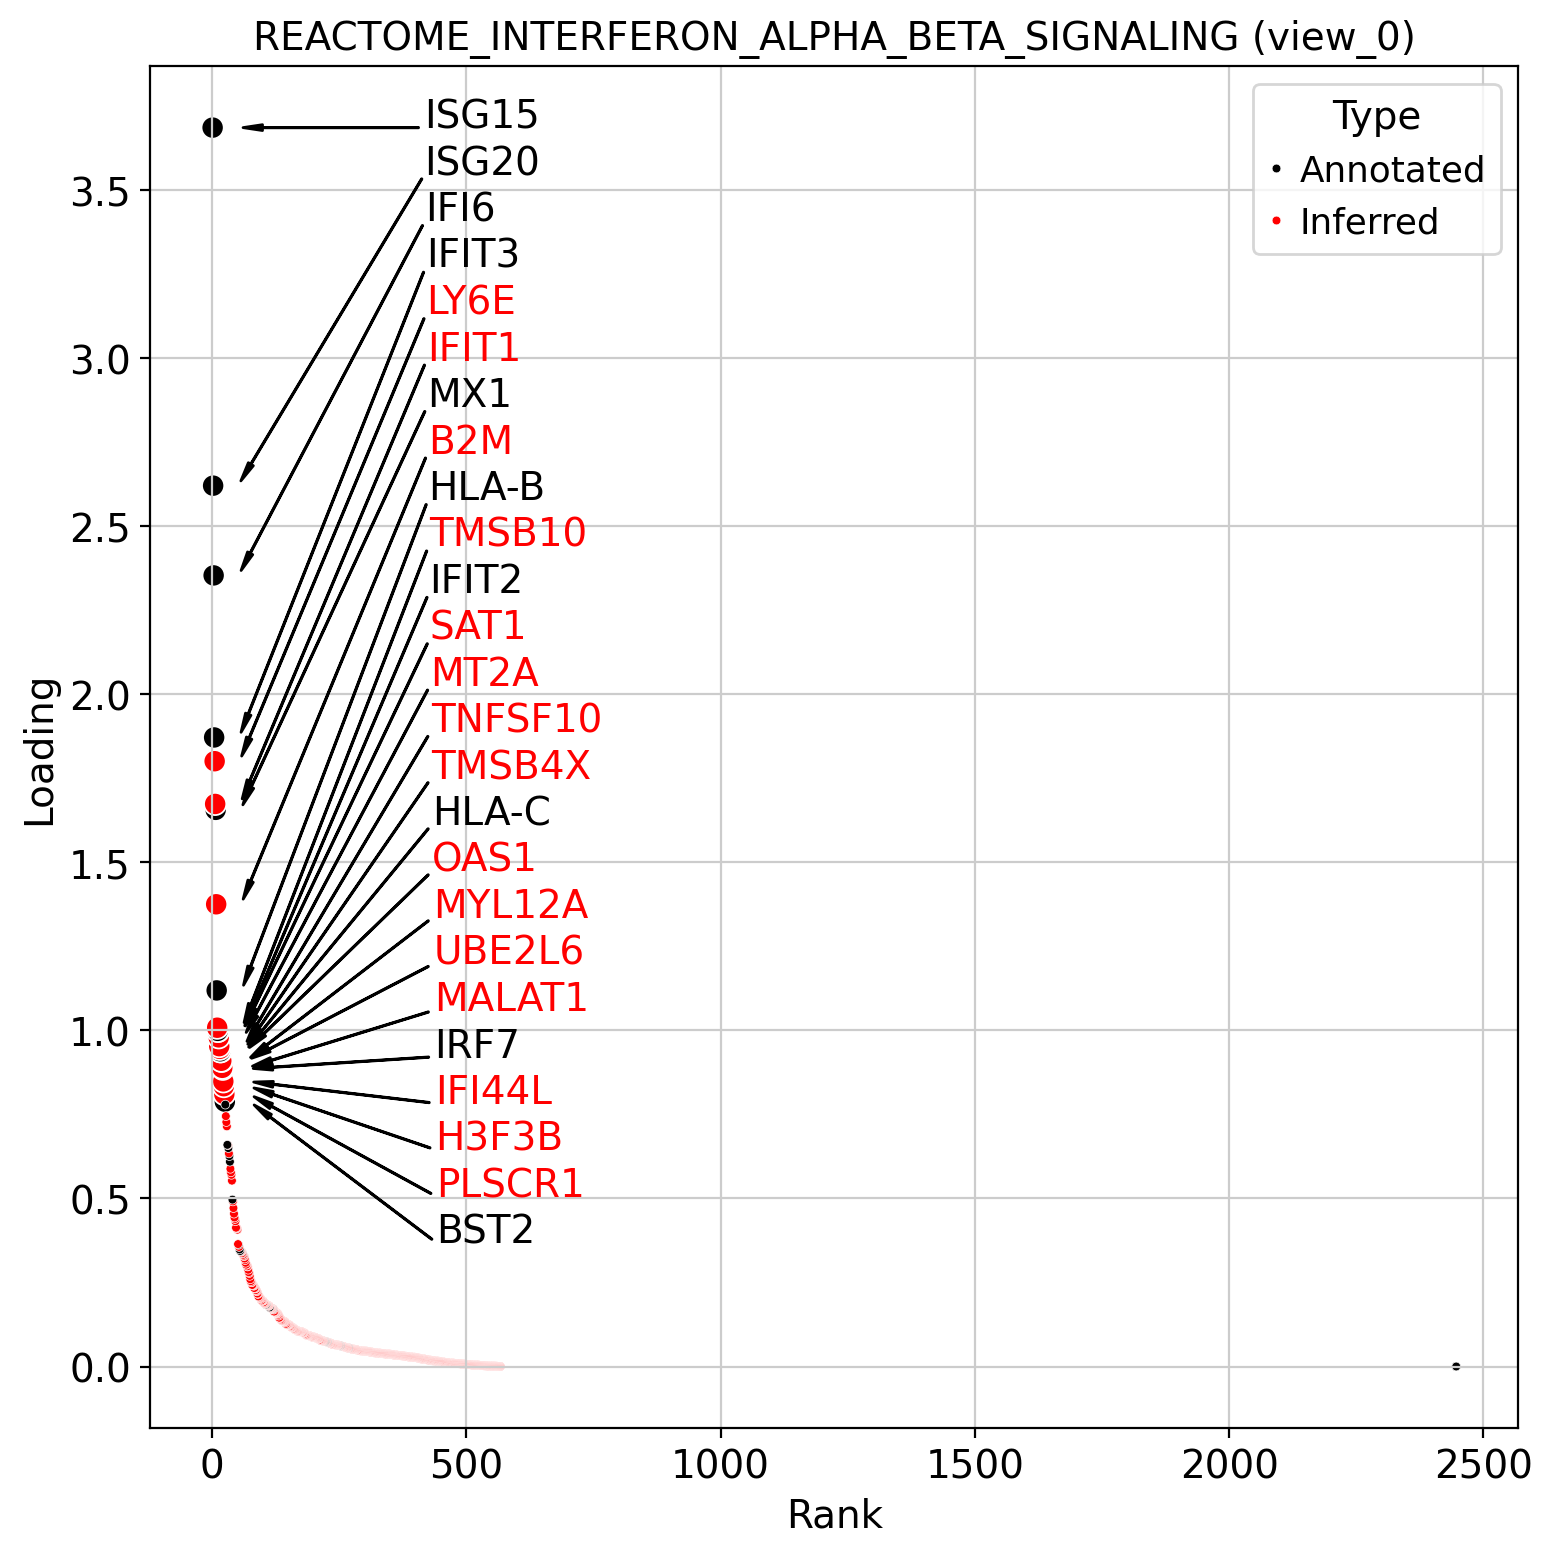

In [87]:
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
plotting.plot_top_weights(
    model,
    "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",
    view_idx="all",
    top=25,
    ranked=True,
)

(<Figure size 1600x1600 with 1 Axes>,
 array([[<Axes: title={'center': 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR (view_0)'}, xlabel='Rank', ylabel='Loading'>]],
       dtype=object))

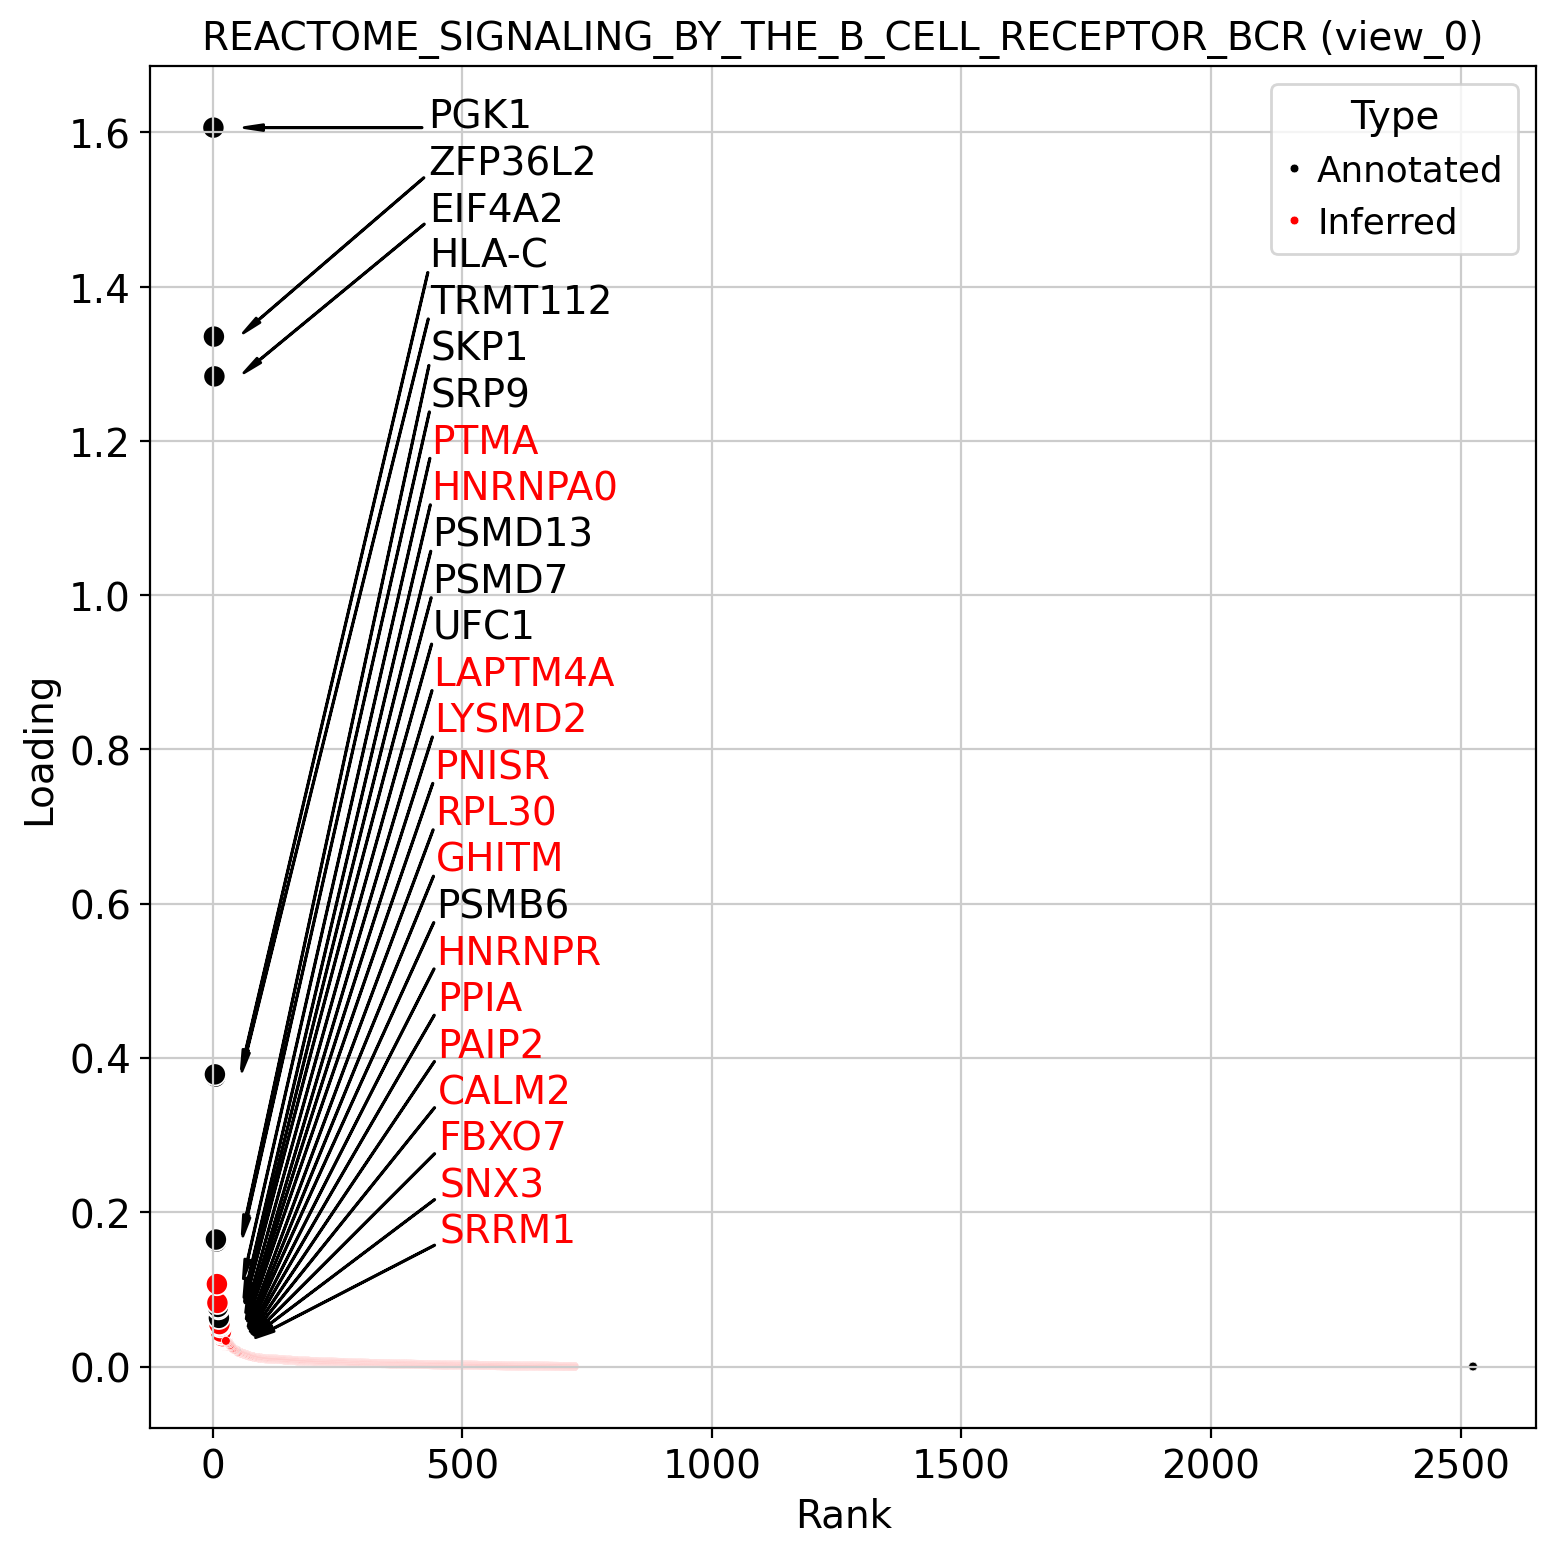

In [88]:
# plotting.plot_top_weights(model, "view_0", factor=4, nfeatures=10)
plotting.plot_top_weights(
    model,
    "REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR",
    view_idx="all",
    top=25,
    ranked=True,
)